# BoVW experimentation

Team 6
* Gerard Vilaplana
* Adrià Ruiz
* Aleix Armero
* Arnau Marcos
* Lore Oregi

# Introduction

The experimentation pipeline will be the following: We'll take a baseline configuration detailed below, and we're going to perform experiments in diferent aspects of the whole pipeline. As we make those experiments, we'll update the baseline keeping the balance with the best results from the previous experiments and hyperparameters that don't compromise the experimentation speed. We're going to use the following baseline for experimentation:
- Descriptor: SIFT, as the common algorithm for feature extraction in classic literature
- Number of features: 500
- Size of codebook: 512 (For initial fast clustering experimentation)
- Normalization: L2 in histograms
- Spatial Pyramids: No pyramid (no level)
- Dimensionality reuction: None (first we try with the whole data)
- Classifier: Logistic Regression (fast and easy hyperparameters for base experimentation)


With this pipeline, we're going to try:
- Number of local features in descriptors
- SIFT / AKAZE / ORB / Dense SIFT
- Spatial pyramids vs no spatial pyramids
- Try normalization and scale
- Size of codebook
- Try dimensionality reduction
- Classifiers: Logistic Regression vs SVM vs KNN
- Fisher Vectors

All experiments are evaluated using stratified 5-fold cross-validation to ensure reliable and consistent performance results. Only the best-performing configuration (based on cross-validation results) is then retrained on the full training set and evaluated once on the held-out test set.


In [1]:
from main import *
from bovw import *
from plotting import *

import os
import random
import numpy as np
import pandas as pd

%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

# Dataset Overview

In [3]:
data_train = Dataset(ImageFolder="../data/places_reduced/train")
data_test = Dataset(ImageFolder="../data/places_reduced/val")

len(data_train), len(data_test)

(8700, 2200)

In [4]:
train_sizes = set([img.size for img, _ in data_train])
print("Train unique sizes:", train_sizes)

test_sizes = set([img.size for img, _ in data_test])
print("Test unique sizes:", test_sizes)

Train unique sizes: {(256, 256)}
Test unique sizes: {(256, 256)}


In [5]:
random.shuffle(data_train)
random.shuffle(data_test)

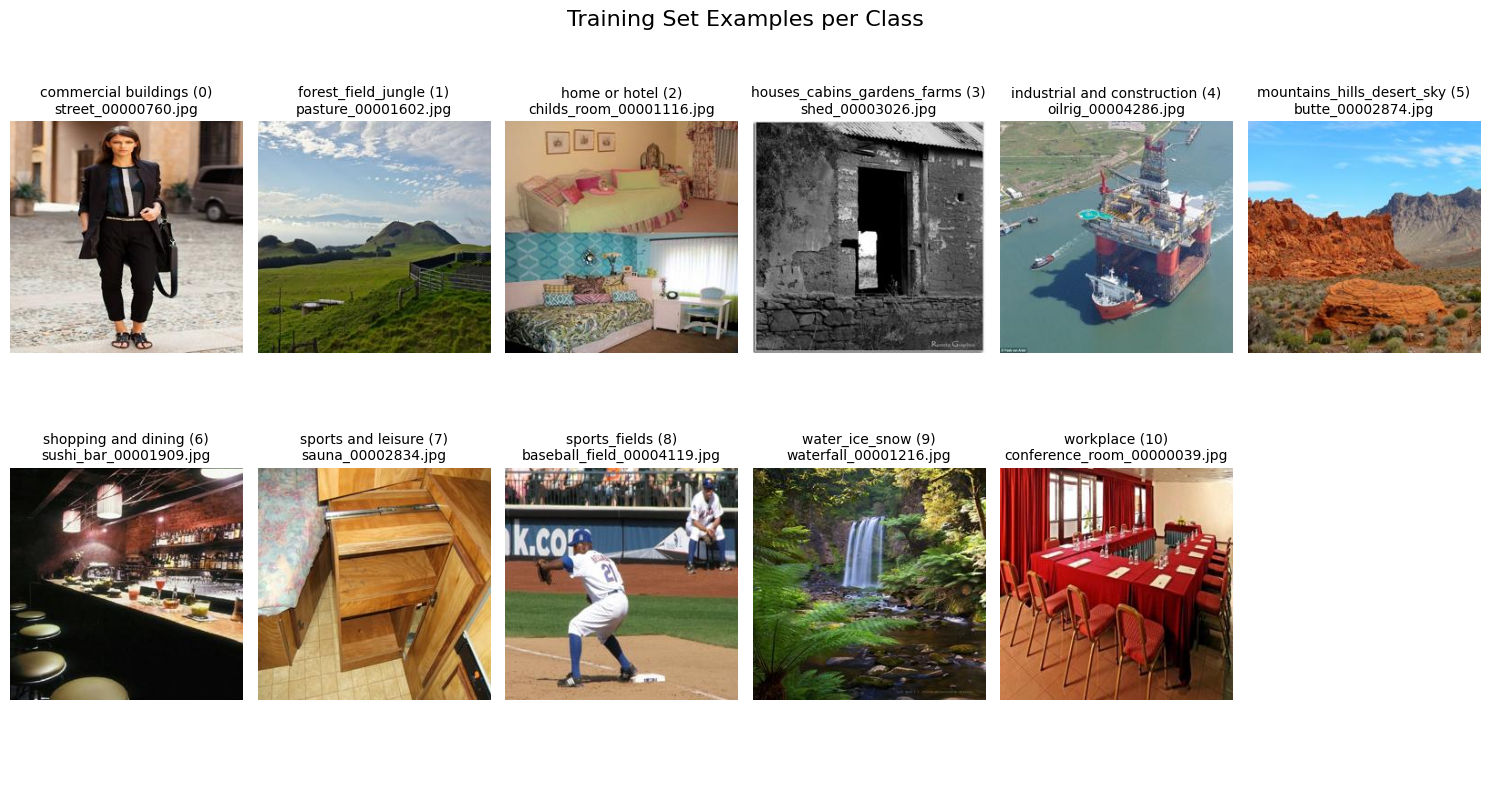

In [13]:
examples = []
seen_classes = set()

for img, label in data_train:
    class_name = os.path.basename(os.path.dirname(img.filename))
    if class_name not in seen_classes:
        examples.append((img, label))
        seen_classes.add(class_name)

examples.sort(key=lambda x: x[1])

plot_images(examples, title="Training Set Examples per Class", figsize=(15, 8), max_cols=6)

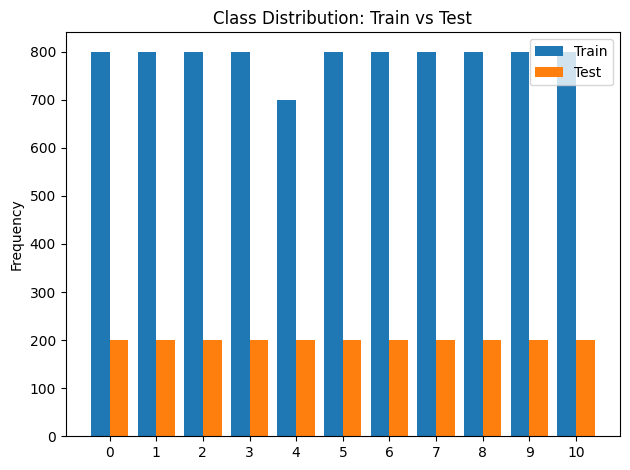

In [6]:
train_class_counter = Counter(entry[1] for entry in data_train)
test_class_counter = Counter(entry[1] for entry in data_test)

classes = sorted(train_class_counter.keys())  # or union with test if needed
train_counts = [train_class_counter[c] for c in classes]
test_counts = [test_class_counter[c] for c in classes]

width = 0.4
x = range(len(classes))

plt.bar([xi - width/2 for xi in x], train_counts, width=width, label="Train")
plt.bar([xi + width/2 for xi in x], test_counts, width=width, label="Test")

plt.xticks(x, classes)
plt.ylabel("Frequency")
plt.title("Class Distribution: Train vs Test")
plt.legend()
plt.tight_layout()
plt.show()

All classes have 800 training images except for class 4 ("industrial and construction"), which has 700.

All classes have 200 test samples.

# Experiments

In [ ]:
#Execution example:
"""
bovw_params = {
    "detector_type": "DSIFT",
    "codebook_size": 100, 
    "detector_kwargs": {"nfeatures": 100},
    "dense_kwargs": {"step": 16, "size": 16}
}

classifier_cls = SVC
classifier_params = {
    "kernel": 'rbf', 
}

scores = cross_validate_bovw(
    data_train,
    bovw_kwargs=bovw_params,
    classifier_cls=classifier_cls,
    classifier_kwargs=classifier_params
)

scores.test.accuracy.mean
"""

'\nbovw_params = {\n    "detector_type": "DSIFT",\n    "codebook_size": 100, \n    "detector_kwargs": {"nfeatures": 100},\n    "dense_kwargs": {"step": 16, "size": 16}\n}\n\nclassifier_cls = SVC\nclassifier_params = {\n    "kernel": \'rbf\', \n}\n\nscores = cross_validate_bovw(\n    data_train,\n    bovw_kwargs=bovw_params,\n    classifier_cls=classifier_cls,\n    classifier_kwargs=classifier_params\n)\n\nscores.test.accuracy.mean\n'

## A) Descriptors (SIFT vs AKAZE vs ORB) and number of features

In this first experiment, we analyze how the number of extracted local features and the specific descriptor used influence the performance of the classification pipeline. We seek to answer the following questions:

* How does increasing or reducing the number of local features affect accuracy?

* To what extent does the type of descriptor (SIFT, AKAZE, ORB) impact the final performance?

For AKAZE, the number of extracted keypoints is not directly controlled through a parameter like in SIFT or ORB. Instead, we vary the detector threshold, which indirectly regulates keypoint density: lower thresholds produce more local features, while higher thresholds result in fewer and more selective keypoints.

In [11]:
enable_cache()

### SIFT

In [6]:
# SIFT
print("TESTING SIFT DESCRIPTOR")

sift_nfeatures = [250, 500, 1000, 2000, 10000]
sift_results = {}

for nfeatures in sift_nfeatures:
    print(f"\nSIFT with nfeatures={nfeatures}")
    
    bovw_params = {
        "detector_type": "SIFT",
        "codebook_size": 512,
        "detector_kwargs": {"nfeatures": nfeatures},
    }
    
    classifier_cls = LogisticRegression
    classifier_params = {
        "max_iter": 1000,
        "class_weight": "balanced",
    }
    
    scores = cross_validate_bovw(
        data_train,
        bovw_kwargs=bovw_params,
        classifier_cls=classifier_cls,
        classifier_kwargs=classifier_params,
        n_splits=5,
        verbose=False,
    )
    
    sift_results[nfeatures] = scores
    
    print(f"[SIFT nfeatures={nfeatures}] Results:")
    print(f"  Train Accuracy:  {scores.train.accuracy.mean:.4f} ± {scores.train.accuracy.std:.4f}")
    print(f"  Val Accuracy:   {scores.val.accuracy.mean:.4f} ± {scores.val.accuracy.std:.4f}")
    print(f"  Val Precision:  {scores.val.precision.mean:.4f} ± {scores.val.precision.std:.4f}")
    print(f"  Val Recall:     {scores.val.recall.mean:.4f} ± {scores.val.recall.std:.4f}")
    print(f"  Val F1-Score:   {scores.val.f1.mean:.4f} ± {scores.val.f1.std:.4f}")


print("\nSIFT SUMMARY")
for nfeatures in sift_nfeatures:
    print(f"nfeatures={nfeatures:4d} -> Accuracy Train: {sift_results[nfeatures].train.accuracy.mean:.4f} ± {sift_results[nfeatures].train.accuracy.std:.4f}")
    print(f"nfeatures={nfeatures:4d} -> Accuracy Val: {sift_results[nfeatures].val.accuracy.mean:.4f} ± {sift_results[nfeatures].val.accuracy.std:.4f}")
    print("")

TESTING SIFT DESCRIPTOR

SIFT with nfeatures=250


Phase [Setup]: Extracting the descriptors:  23%|██▎       | 2033/8700 [00:00<00:02, 3306.76it/s]

Could not compute descriptors for image ../data/places_reduced/train/water_ice_snow/iceberg_00000023.jpg of class 9.


Phase [Setup]: Extracting the descriptors:  62%|██████▏   | 5384/8700 [00:01<00:01, 3188.73it/s]

Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/sky_00001410.jpg of class 5.


100%|██████████| 5/5 [01:05<00:00, 13.03s/it]


[SIFT nfeatures=250] Results:
  Train Accuracy:  0.4335 ± 0.0058
  Val Accuracy:   0.2899 ± 0.0184
  Val Precision:  0.2791 ± 0.0192
  Val Recall:     0.2899 ± 0.0184
  Val F1-Score:   0.2814 ± 0.0191

SIFT with nfeatures=500


Phase [Setup]: Extracting the descriptors:  20%|██        | 1776/8700 [00:00<00:03, 2248.12it/s]

Could not compute descriptors for image ../data/places_reduced/train/water_ice_snow/iceberg_00000023.jpg of class 9.


Phase [Setup]: Extracting the descriptors:  58%|█████▊    | 5050/8700 [00:02<00:01, 2272.72it/s]

Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/sky_00001410.jpg of class 5.


100%|██████████| 5/5 [01:14<00:00, 14.83s/it]


[SIFT nfeatures=500] Results:
  Train Accuracy:  0.4431 ± 0.0039
  Val Accuracy:   0.3120 ± 0.0203
  Val Precision:  0.3034 ± 0.0208
  Val Recall:     0.3120 ± 0.0203
  Val F1-Score:   0.3046 ± 0.0203

SIFT with nfeatures=1000


Phase [Setup]: Extracting the descriptors:  20%|██        | 1783/8700 [00:01<00:03, 1776.05it/s]

Could not compute descriptors for image ../data/places_reduced/train/water_ice_snow/iceberg_00000023.jpg of class 9.


Phase [Setup]: Extracting the descriptors:  58%|█████▊    | 5077/8700 [00:02<00:02, 1795.22it/s]

Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/sky_00001410.jpg of class 5.


100%|██████████| 5/5 [01:29<00:00, 17.97s/it]


[SIFT nfeatures=1000] Results:
  Train Accuracy:  0.4510 ± 0.0057
  Val Accuracy:   0.3288 ± 0.0216
  Val Precision:  0.3191 ± 0.0218
  Val Recall:     0.3288 ± 0.0216
  Val F1-Score:   0.3207 ± 0.0216

SIFT with nfeatures=2000


Phase [Setup]: Extracting the descriptors:  20%|█▉        | 1720/8700 [00:01<00:04, 1713.25it/s]

Could not compute descriptors for image ../data/places_reduced/train/water_ice_snow/iceberg_00000023.jpg of class 9.


Phase [Setup]: Extracting the descriptors:  58%|█████▊    | 5009/8700 [00:02<00:02, 1727.56it/s]

Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/sky_00001410.jpg of class 5.


100%|██████████| 5/5 [01:34<00:00, 18.82s/it]


[SIFT nfeatures=2000] Results:
  Train Accuracy:  0.4477 ± 0.0031
  Val Accuracy:   0.3218 ± 0.0111
  Val Precision:  0.3138 ± 0.0111
  Val Recall:     0.3218 ± 0.0111
  Val F1-Score:   0.3143 ± 0.0110

SIFT with nfeatures=10000


Phase [Setup]: Extracting the descriptors:  20%|██        | 1781/8700 [00:01<00:03, 1762.97it/s]

Could not compute descriptors for image ../data/places_reduced/train/water_ice_snow/iceberg_00000023.jpg of class 9.


Phase [Setup]: Extracting the descriptors:  58%|█████▊    | 5063/8700 [00:02<00:02, 1790.37it/s]

Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/sky_00001410.jpg of class 5.


100%|██████████| 5/5 [01:29<00:00, 17.94s/it]

[SIFT nfeatures=10000] Results:
  Train Accuracy:  0.4508 ± 0.0050
  Val Accuracy:   0.3244 ± 0.0160
  Val Precision:  0.3154 ± 0.0154
  Val Recall:     0.3244 ± 0.0160
  Val F1-Score:   0.3168 ± 0.0156

SIFT SUMMARY
nfeatures= 250 -> Accuracy Train: 0.4335 ± 0.0058
nfeatures= 250 -> Accuracy Val: 0.2899 ± 0.0184

nfeatures= 500 -> Accuracy Train: 0.4431 ± 0.0039
nfeatures= 500 -> Accuracy Val: 0.3120 ± 0.0203

nfeatures=1000 -> Accuracy Train: 0.4510 ± 0.0057
nfeatures=1000 -> Accuracy Val: 0.3288 ± 0.0216

nfeatures=2000 -> Accuracy Train: 0.4477 ± 0.0031
nfeatures=2000 -> Accuracy Val: 0.3218 ± 0.0111

nfeatures=10000 -> Accuracy Train: 0.4508 ± 0.0050
nfeatures=10000 -> Accuracy Val: 0.3244 ± 0.0160



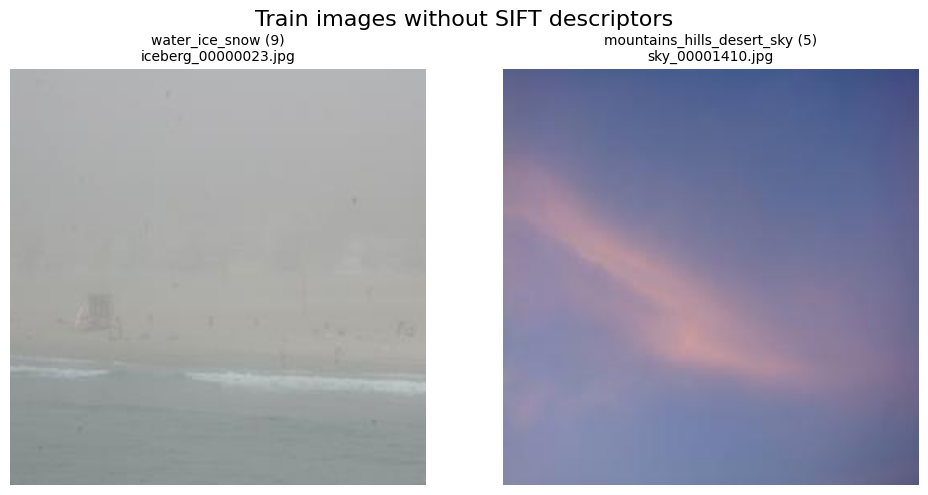

In [ ]:
# Check which images failed to compute SIFT descriptors
FAILED_PATHS = {
    "../data/places_reduced/train/water_ice_snow/iceberg_00000023.jpg",
    "../data/places_reduced/train/mountains_hills_desert_sky/sky_00001410.jpg"
}

failed_images_for_plot: List[Tuple[Type[Image.Image], int]] = []

for img_pil, label in data_train:
    if hasattr(img_pil, 'filename') and img_pil.filename in FAILED_PATHS:
        failed_images_for_plot.append((img_pil, label))

if failed_images_for_plot:
    plot_images(
        failed_images_for_plot, 
        title="Train images without SIFT descriptors",
        figsize=(10, 5),
        max_cols=2
    )

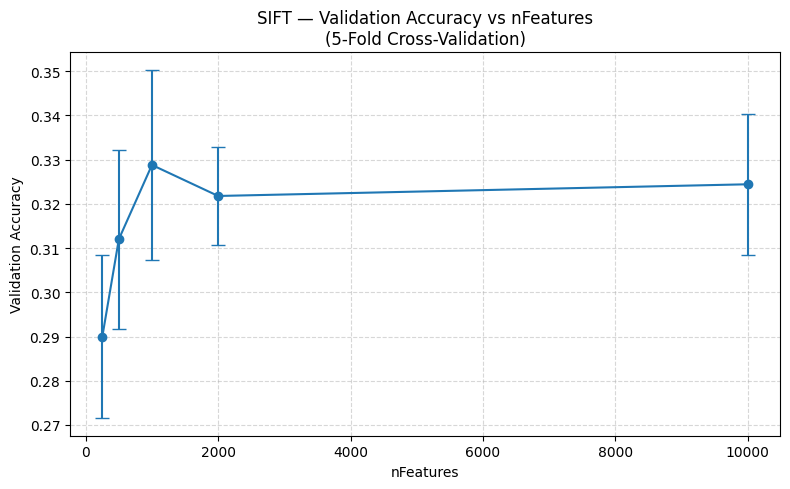

In [7]:
# Plot SIFT Validation Accuracy vs nFeatures (5-Fold CV)

# Since the dataset is reasonably balanced and we use stratified 5-fold cross-validation, 
# accuracy is a reliable metric for evaluating performance in this experiment.

n_features = sift_nfeatures

acc_means = [sift_results[n].val.accuracy.mean for n in n_features]
acc_stds  = [sift_results[n].val.accuracy.std for n in n_features]

plot_cv_accuracy(
    x_values=n_features,
    means=acc_means,
    stds=acc_stds,
    descriptor_name="SIFT",
    hyperparam_name="nFeatures"
)


In [5]:
# Tested on the held-out test set using the best nFeatures selected by cross-validation (1000)
bovw_params = {
    "detector_type": "SIFT",
    "codebook_size": 512,
    "detector_kwargs": {"nfeatures": 1000},
}

classifier_cls = LogisticRegression
classifier_params = {
    "max_iter": 1000,
    "class_weight": "balanced",
}
bovw = BOVW(**bovw_params)
classifier = classifier_cls(**classifier_params)
sift_bovw, sift_classifier = train(dataset=data_train, bovw=bovw, classifier=classifier)

sift_acc, sift_prec, sift_rec, sift_f1, sift_y_test, sift_y_pred, sift_y_score = test(dataset=data_test, bovw=sift_bovw, classifier=sift_classifier, return_predictions=True)

Phase [Training]: Extracting the descriptors: 100%|██████████| 8700/8700 [00:05<00:00, 1508.61it/s]


Fitting the codebook
Computing the bovw histograms
Fitting the classifier
Accuracy on Phase[Train]: 0.4405610485169004
Precision on Phase[Train]: 0.43610723880646035
Recall on Phase[Train]: 0.4405610485169004
F1-Score on Phase[Train]: 0.434642928998042


Phase [Eval]: Extracting the descriptors: 100%|██████████| 2200/2200 [00:01<00:00, 1669.25it/s]


Computing the bovw histograms
predicting the values
Accuracy on Phase[Test]: 0.33181818181818185
Precision on Phase[Test]: 0.32283453990023575
Recall on Phase[Test]: 0.33181818181818185
F1-Score on Phase[Test]: 0.3214347408215836


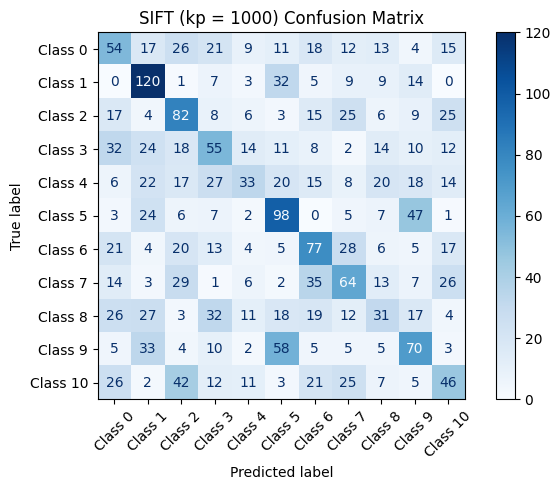

In [6]:
plot_confusion_matrix(sift_y_test, sift_y_pred, title="SIFT (kp = 1000) Confusion Matrix")

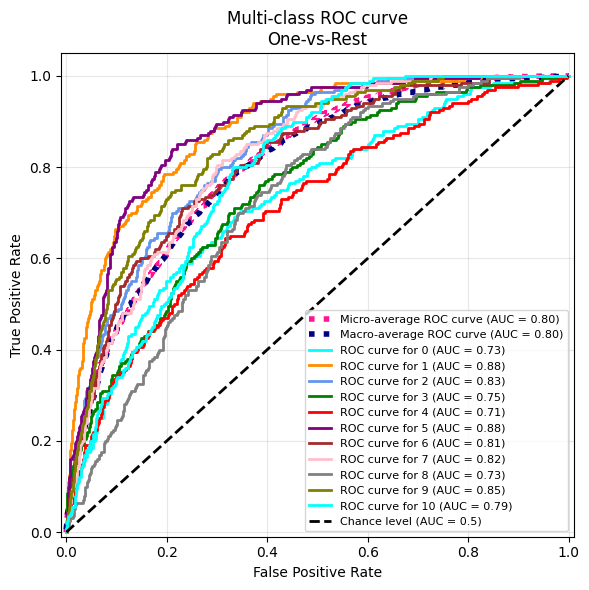


Micro-averaged One-vs-Rest ROC AUC score: 0.80
Macro-averaged One-vs-Rest ROC AUC score: 0.80

Per-class ROC AUC scores:
  0: 0.73
  1: 0.88
  2: 0.83
  3: 0.75
  4: 0.71
  5: 0.88
  6: 0.81
  7: 0.82
  8: 0.73
  9: 0.85
  10: 0.79


In [7]:
plot_multiclass_roc(sift_y_test, sift_y_score, figsize=(6,6))

### AKAZE

In [8]:
# AKAZE
print("TESTING AKAZE DESCRIPTOR")

akaze_threshold = [0.0004, 0.0008, 0.0012]
akaze_results = {}

for thr in akaze_threshold:
    print(f"\nAKAZE with threshold={thr}")
    
    bovw_params = {
        "detector_type": "AKAZE",
        "codebook_size": 512,
        "detector_kwargs": {"threshold": thr},
    }
    
    classifier_cls = LogisticRegression
    classifier_params = {
        "max_iter": 1000,
        "class_weight": "balanced",
    }
    
    scores = cross_validate_bovw(
        data_train,
        bovw_kwargs=bovw_params,
        classifier_cls=classifier_cls,
        classifier_kwargs=classifier_params,
        n_splits=5,
        verbose=False,
    )
    
    akaze_results[thr] = scores
    
    print(f"[AKAZE threshold={thr}] Results:")
    print(f"  Train Accuracy:  {scores.train.accuracy.mean:.4f} ± {scores.train.accuracy.std:.4f}")
    print(f"  Val Accuracy:   {scores.val.accuracy.mean:.4f} ± {scores.val.accuracy.std:.4f}")
    print(f"  Val Precision:  {scores.val.precision.mean:.4f} ± {scores.val.precision.std:.4f}")
    print(f"  Val Recall:     {scores.val.recall.mean:.4f} ± {scores.val.recall.std:.4f}")
    print(f"  Val F1-Score:   {scores.val.f1.mean:.4f} ± {scores.val.f1.std:.4f}")

print("\nAKAZE SUMMARY")
for thr in akaze_threshold:
    print(f"thr={thr} -> Accuracy Train: {akaze_results[thr].train.accuracy.mean:.4f} ± {akaze_results[thr].train.accuracy.std:.4f}")
    print(f"thr={thr} -> Accuracy Val: {akaze_results[thr].val.accuracy.mean:.4f} ± {akaze_results[thr].val.accuracy.std:.4f}")
    print("")

TESTING AKAZE DESCRIPTOR

AKAZE with threshold=0.0004


Phase [Setup]: Extracting the descriptors:   6%|▋         | 549/8700 [00:01<00:31, 261.26it/s]

Could not compute descriptors for image ../data/places_reduced/train/water_ice_snow/iceberg_00000023.jpg of class 9.


Phase [Setup]: Extracting the descriptors:  12%|█▏        | 1056/8700 [00:03<00:30, 251.51it/s]

Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/sky_00001410.jpg of class 5.


Phase [Setup]: Extracting the descriptors:  46%|████▌     | 3969/8700 [00:12<00:13, 349.60it/s]

Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/volcano_00004486.jpg of class 5.


Phase [Setup]: Extracting the descriptors:  65%|██████▍   | 5647/8700 [00:17<00:10, 303.56it/s]

Could not compute descriptors for image ../data/places_reduced/train/sports and leisure/sauna_00001030.jpg of class 7.


Phase [Setup]: Extracting the descriptors:  77%|███████▋  | 6665/8700 [00:20<00:04, 426.41it/s]

Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/canyon_00003418.jpg of class 5.


Phase [Setup]: Extracting the descriptors:  83%|████████▎ | 7254/8700 [00:22<00:03, 406.81it/s]

Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/sky_00001057.jpg of class 5.


Phase [Setup]: Extracting the descriptors:  89%|████████▉ | 7737/8700 [00:23<00:02, 408.51it/s]

Could not compute descriptors for image ../data/places_reduced/train/sports and leisure/sauna_00003623.jpg of class 7.


100%|██████████| 5/5 [03:18<00:00, 39.63s/it]


[AKAZE threshold=0.0004] Results:
  Train Accuracy:  0.3678 ± 0.0046
  Val Accuracy:   0.2112 ± 0.0093
  Val Precision:  0.2058 ± 0.0093
  Val Recall:     0.2112 ± 0.0093
  Val F1-Score:   0.2060 ± 0.0086

AKAZE with threshold=0.0008


Phase [Setup]: Extracting the descriptors:   6%|▋         | 553/8700 [00:01<00:22, 363.46it/s]

Could not compute descriptors for image ../data/places_reduced/train/water_ice_snow/iceberg_00000023.jpg of class 9.


Phase [Setup]: Extracting the descriptors:  12%|█▏        | 1079/8700 [00:02<00:20, 374.95it/s]

Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/sky_00001410.jpg of class 5.


Phase [Setup]: Extracting the descriptors:  29%|██▊       | 2489/8700 [00:05<00:15, 403.23it/s]

Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/sky_00004426.jpg of class 5.


Phase [Setup]: Extracting the descriptors:  36%|███▌      | 3092/8700 [00:06<00:05, 984.08it/s]

Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/mountain_00002707.jpg of class 5.


Phase [Setup]: Extracting the descriptors:  41%|████      | 3572/8700 [00:07<00:11, 440.45it/s]

Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/sky_00000137.jpg of class 5.


Phase [Setup]: Extracting the descriptors:  47%|████▋     | 4056/8700 [00:08<00:05, 901.77it/s]

Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/volcano_00004486.jpg of class 5.


Phase [Setup]: Extracting the descriptors:  60%|█████▉    | 5195/8700 [00:10<00:09, 375.81it/s]

Could not compute descriptors for image ../data/places_reduced/train/forest_field_jungle/pasture_00002164.jpg of class 1.


Phase [Setup]: Extracting the descriptors:  63%|██████▎   | 5497/8700 [00:11<00:07, 408.06it/s]

Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/cliff_00001485.jpg of class 5.


Phase [Setup]: Extracting the descriptors:  65%|██████▌   | 5660/8700 [00:11<00:08, 365.70it/s]

Could not compute descriptors for image ../data/places_reduced/train/sports and leisure/sauna_00001030.jpg of class 7.


Phase [Setup]: Extracting the descriptors:  72%|███████▏  | 6240/8700 [00:13<00:06, 393.72it/s]

Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/cliff_00001932.jpg of class 5.


Phase [Setup]: Extracting the descriptors:  77%|███████▋  | 6664/8700 [00:14<00:05, 389.00it/s]

Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/canyon_00003418.jpg of class 5.


Phase [Setup]: Extracting the descriptors:  79%|███████▉  | 6857/8700 [00:14<00:05, 358.25it/s]

Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/sky_00000226.jpg of class 5.


Phase [Setup]: Extracting the descriptors:  85%|████████▌ | 7412/8700 [00:15<00:01, 990.15it/s]

Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/sky_00001057.jpg of class 5.


Phase [Setup]: Extracting the descriptors:  89%|████████▉ | 7740/8700 [00:15<00:00, 1001.90it/s]

Could not compute descriptors for image ../data/places_reduced/train/sports and leisure/sauna_00003623.jpg of class 7.


100%|██████████| 5/5 [02:36<00:00, 31.40s/it]


[AKAZE threshold=0.0008] Results:
  Train Accuracy:  0.3630 ± 0.0020
  Val Accuracy:   0.1965 ± 0.0079
  Val Precision:  0.1914 ± 0.0071
  Val Recall:     0.1965 ± 0.0079
  Val F1-Score:   0.1916 ± 0.0073

AKAZE with threshold=0.0012


Phase [Setup]: Extracting the descriptors:   6%|▋         | 557/8700 [00:01<00:21, 385.80it/s]

Could not compute descriptors for image ../data/places_reduced/train/water_ice_snow/iceberg_00000023.jpg of class 9.


Phase [Setup]: Extracting the descriptors:  12%|█▏        | 1085/8700 [00:02<00:16, 457.83it/s]

Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/sky_00001410.jpg of class 5.


Phase [Setup]: Extracting the descriptors:  15%|█▍        | 1270/8700 [00:02<00:17, 426.34it/s]

Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/sky_00003849.jpg of class 5.


Phase [Setup]: Extracting the descriptors:  16%|█▌        | 1353/8700 [00:03<00:18, 389.52it/s]

Could not compute descriptors for image ../data/places_reduced/train/home or hotel/bathroom_00000599.jpg of class 2.


Phase [Setup]: Extracting the descriptors:  19%|█▉        | 1635/8700 [00:03<00:15, 445.81it/s]

Could not compute descriptors for image ../data/places_reduced/train/water_ice_snow/hot_spring_00003968.jpg of class 9.


Phase [Setup]: Extracting the descriptors:  28%|██▊       | 2476/8700 [00:05<00:13, 478.18it/s]

Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/sky_00004426.jpg of class 5.
Could not compute descriptors for image ../data/places_reduced/train/sports_fields/promenade_00000058.jpg of class 8.


Phase [Setup]: Extracting the descriptors:  36%|███▋      | 3161/8700 [00:07<00:12, 455.12it/s]

Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/mountain_00002707.jpg of class 5.


Phase [Setup]: Extracting the descriptors:  41%|████      | 3580/8700 [00:07<00:10, 471.69it/s]

Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/sky_00000137.jpg of class 5.


Phase [Setup]: Extracting the descriptors:  46%|████▌     | 3995/8700 [00:08<00:10, 459.79it/s]

Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/volcano_00004486.jpg of class 5.


Phase [Setup]: Extracting the descriptors:  53%|█████▎    | 4618/8700 [00:10<00:09, 428.36it/s]

Could not compute descriptors for image ../data/places_reduced/train/home or hotel/basement_00001438.jpg of class 2.


Phase [Setup]: Extracting the descriptors:  57%|█████▋    | 4990/8700 [00:11<00:08, 430.53it/s]

Could not compute descriptors for image ../data/places_reduced/train/sports and leisure/sauna_00003791.jpg of class 7.


Phase [Setup]: Extracting the descriptors:  59%|█████▉    | 5166/8700 [00:11<00:08, 410.21it/s]

Could not compute descriptors for image ../data/places_reduced/train/forest_field_jungle/pasture_00002164.jpg of class 1.


Phase [Setup]: Extracting the descriptors:  63%|██████▎   | 5494/8700 [00:12<00:06, 467.44it/s]

Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/cliff_00001485.jpg of class 5.


Phase [Setup]: Extracting the descriptors:  65%|██████▌   | 5677/8700 [00:12<00:07, 419.55it/s]

Could not compute descriptors for image ../data/places_reduced/train/sports and leisure/sauna_00001030.jpg of class 7.


Phase [Setup]: Extracting the descriptors:  72%|███████▏  | 6228/8700 [00:13<00:05, 477.80it/s]

Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/cliff_00001932.jpg of class 5.


Phase [Setup]: Extracting the descriptors:  74%|███████▍  | 6474/8700 [00:14<00:05, 416.99it/s]

Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/volcano_00000431.jpg of class 5.
Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/volcano_00002718.jpg of class 5.


Phase [Setup]: Extracting the descriptors:  76%|███████▋  | 6640/8700 [00:14<00:04, 461.29it/s]

Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/canyon_00003418.jpg of class 5.


Phase [Setup]: Extracting the descriptors:  79%|███████▉  | 6883/8700 [00:15<00:04, 439.46it/s]

Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/sky_00000226.jpg of class 5.


Phase [Setup]: Extracting the descriptors:  83%|████████▎ | 7242/8700 [00:15<00:02, 488.28it/s]

Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/sky_00001057.jpg of class 5.


Phase [Setup]: Extracting the descriptors:  90%|█████████ | 7845/8700 [00:17<00:01, 727.99it/s]

Could not compute descriptors for image ../data/places_reduced/train/sports and leisure/sauna_00003623.jpg of class 7.


100%|██████████| 5/5 [02:21<00:00, 28.39s/it]

[AKAZE threshold=0.0012] Results:
  Train Accuracy:  0.3510 ± 0.0023
  Val Accuracy:   0.1949 ± 0.0060
  Val Precision:  0.1889 ± 0.0055
  Val Recall:     0.1949 ± 0.0060
  Val F1-Score:   0.1897 ± 0.0054

AKAZE SUMMARY
thr=0.0004 -> Accuracy Train: 0.3678 ± 0.0046
thr=0.0004 -> Accuracy Val: 0.2112 ± 0.0093

thr=0.0008 -> Accuracy Train: 0.3630 ± 0.0020
thr=0.0008 -> Accuracy Val: 0.1965 ± 0.0079

thr=0.0012 -> Accuracy Train: 0.3510 ± 0.0023
thr=0.0012 -> Accuracy Val: 0.1949 ± 0.0060



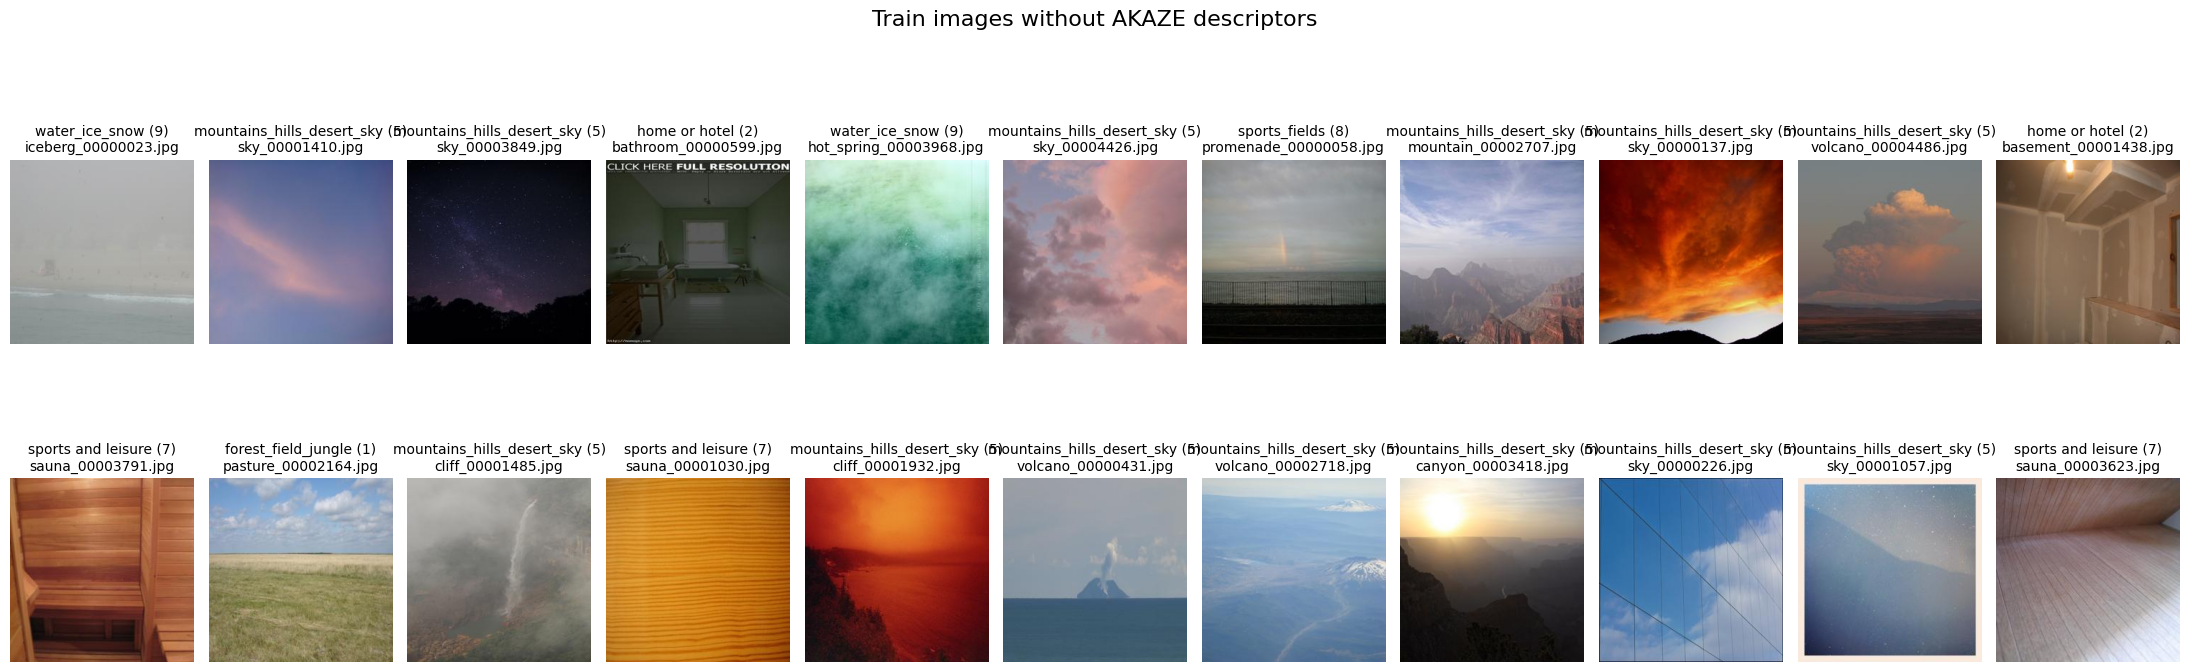

In [33]:
# Check which images failed to compute AKAZE descriptors
# The threshold determines the sensitivity of keypoint detection; higher values may lead to fewer keypoints detected and potenially more failures
FAILED_PATHS = {
    "../data/places_reduced/train/water_ice_snow/iceberg_00000023.jpg",
    "../data/places_reduced/train/mountains_hills_desert_sky/sky_00001410.jpg",
    "../data/places_reduced/train/mountains_hills_desert_sky/volcano_00004486.jpg",
    "../data/places_reduced/train/sports and leisure/sauna_00001030.jpg",
    "../data/places_reduced/train/mountains_hills_desert_sky/canyon_00003418.jpg",
    "../data/places_reduced/train/mountains_hills_desert_sky/sky_00001057.jpg",
    "../data/places_reduced/train/sports and leisure/sauna_00003623.jpg",
    "../data/places_reduced/train/mountains_hills_desert_sky/sky_00004426.jpg",
    "../data/places_reduced/train/mountains_hills_desert_sky/mountain_00002707.jpg",
    "../data/places_reduced/train/mountains_hills_desert_sky/sky_00000137.jpg",
    "../data/places_reduced/train/forest_field_jungle/pasture_00002164.jpg",
    "../data/places_reduced/train/mountains_hills_desert_sky/cliff_00001485.jpg",
    "../data/places_reduced/train/mountains_hills_desert_sky/cliff_00001932.jpg",
    "../data/places_reduced/train/mountains_hills_desert_sky/sky_00000226.jpg",
    "../data/places_reduced/train/mountains_hills_desert_sky/sky_00003849.jpg",
    "../data/places_reduced/train/home or hotel/bathroom_00000599.jpg",
    "../data/places_reduced/train/water_ice_snow/hot_spring_00003968.jpg",
    "../data/places_reduced/train/sports_fields/promenade_00000058.jpg",
    "../data/places_reduced/train/home or hotel/basement_00001438.jpg",
    "../data/places_reduced/train/sports and leisure/sauna_00003791.jpg",
    "../data/places_reduced/train/mountains_hills_desert_sky/volcano_00000431.jpg",
    "../data/places_reduced/train/mountains_hills_desert_sky/volcano_00002718.jpg"
}

failed_images_for_plot: List[Tuple[Type[Image.Image], int]] = []

for img_pil, label in data_train:
    if hasattr(img_pil, 'filename') and img_pil.filename in FAILED_PATHS:
        failed_images_for_plot.append((img_pil, label))

if failed_images_for_plot:
    plot_images(
        failed_images_for_plot, 
        title="Train images without AKAZE descriptors",
        figsize=(22, 8),
        max_cols=11
    )

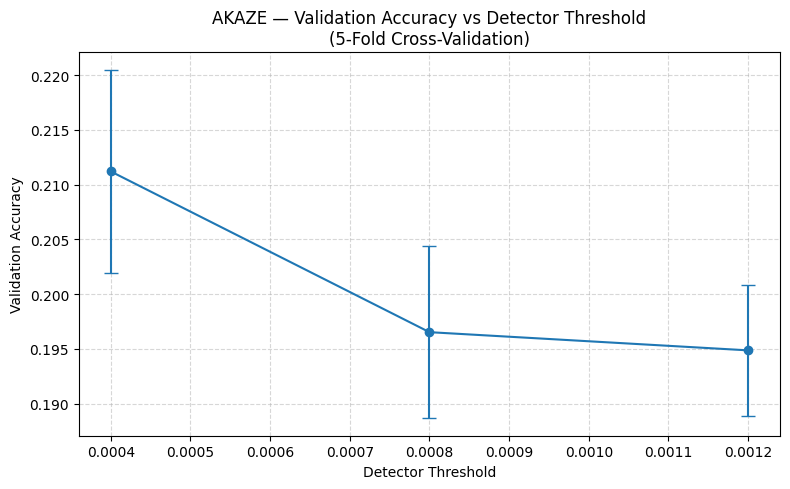

In [9]:
# Plot AKAZE Validation Accuracy vs nFeatures (5-Fold CV)

# Since the dataset is reasonably balanced and we use stratified 5-fold cross-validation, 
# accuracy is a reliable metric for evaluating performance in this experiment.
akaze_thresholds = akaze_threshold

# Accuracy from CV results
acc_means = [akaze_results[t].val.accuracy.mean for t in akaze_thresholds]
acc_stds  = [akaze_results[t].val.accuracy.std for t in akaze_thresholds]

plot_cv_accuracy(
    x_values=akaze_thresholds,
    means=acc_means,
    stds=acc_stds,
    descriptor_name="AKAZE",
    hyperparam_name="Detector Threshold"
)

In [8]:
# Tested on the held-out test set using the best threshold selected by cross-validation (0.0004)
bovw_params = {
    "detector_type": "AKAZE",
    "codebook_size": 512,
    "detector_kwargs": {"threshold": 0.0004},
}

classifier_cls = LogisticRegression
classifier_params = {
    "max_iter": 1000,
    "class_weight": "balanced",
}
bovw = BOVW(**bovw_params)
classifier = classifier_cls(**classifier_params)
akaze_bovw, akaze_classifier = train(dataset=data_train, bovw=bovw, classifier=classifier)

akaze_acc, akaze_prec, akaze_rec, akaze_f1, akaze_y_test, akaze_y_pred, akaze_y_score = test(dataset=data_test, bovw=akaze_bovw, classifier=akaze_classifier, return_predictions=True)

Phase [Training]: Extracting the descriptors: 100%|██████████| 8700/8700 [00:04<00:00, 1940.45it/s]


Fitting the codebook
Computing the bovw histograms
Fitting the classifier
Accuracy on Phase[Train]: 0.3555734499022202
Precision on Phase[Train]: 0.3539390873428095
Recall on Phase[Train]: 0.3555734499022202
F1-Score on Phase[Train]: 0.35153460699223676


Phase [Eval]: Extracting the descriptors: 100%|██████████| 2200/2200 [00:01<00:00, 2115.98it/s]


Computing the bovw histograms
predicting the values
Accuracy on Phase[Test]: 0.20772727272727273
Precision on Phase[Test]: 0.19903872698631944
Recall on Phase[Test]: 0.20772727272727273
F1-Score on Phase[Test]: 0.20102913673902598


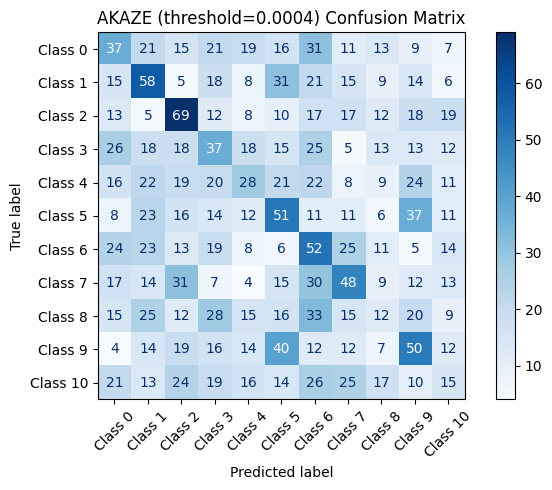

In [9]:
plot_confusion_matrix(akaze_y_test, akaze_y_pred, title="AKAZE (threshold=0.0004) Confusion Matrix")

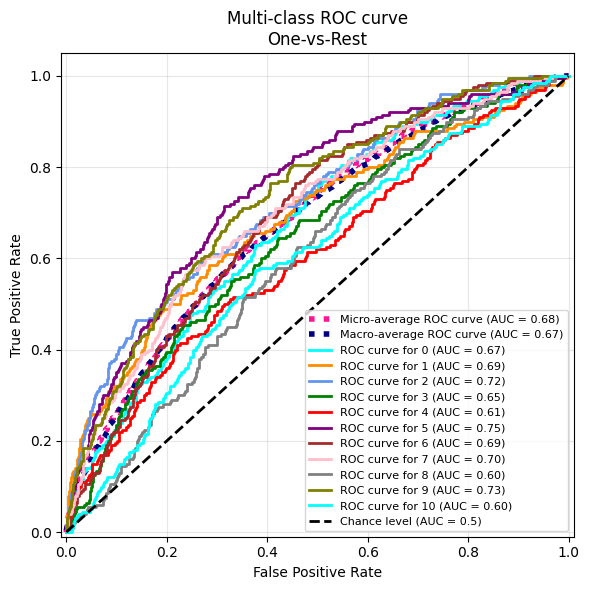


Micro-averaged One-vs-Rest ROC AUC score: 0.68
Macro-averaged One-vs-Rest ROC AUC score: 0.67

Per-class ROC AUC scores:
  0: 0.67
  1: 0.69
  2: 0.72
  3: 0.65
  4: 0.61
  5: 0.75
  6: 0.69
  7: 0.70
  8: 0.60
  9: 0.73
  10: 0.60


In [10]:
plot_multiclass_roc(akaze_y_test, akaze_y_score, figsize=(6,6))

### ORB

In [12]:
# ORB
print("TESTING ORB DESCRIPTOR")

orb_nfeatures = [250, 500, 1000, 2000, 10000]
orb_results = {}

for nfeatures in orb_nfeatures:
    print(f"\nORB with nfeatures={nfeatures}")
    
    bovw_params = {
        "detector_type": "ORB",
        "codebook_size": 512,
        "detector_kwargs": {"nfeatures": nfeatures},
    }
    
    classifier_cls = LogisticRegression
    classifier_params = {
        "max_iter": 1000,
        "class_weight": "balanced",
    }
    
    scores = cross_validate_bovw(
        data_train,
        bovw_kwargs=bovw_params,
        classifier_cls=classifier_cls,
        classifier_kwargs=classifier_params,
        n_splits=5,
        verbose=False,
    )
    
    orb_results[nfeatures] = scores
    
    print(f"[ORB nfeatures={nfeatures}] Results:")
    print(f"  Train Accuracy:  {scores.train.accuracy.mean:.4f} ± {scores.train.accuracy.std:.4f}")
    print(f"  Val Accuracy:   {scores.val.accuracy.mean:.4f} ± {scores.val.accuracy.std:.4f}")
    print(f"  Val Precision:  {scores.val.precision.mean:.4f} ± {scores.val.precision.std:.4f}")
    print(f"  Val Recall:     {scores.val.recall.mean:.4f} ± {scores.val.recall.std:.4f}")
    print(f"  Val F1-Score:   {scores.val.f1.mean:.4f} ± {scores.val.f1.std:.4f}")

print("\nORB SUMMARY")
for nfeatures in orb_nfeatures:
    print(f"nfeatures={nfeatures:4d} -> Accuracy Train: {orb_results[nfeatures].train.accuracy.mean:.4f} ± {orb_results[nfeatures].train.accuracy.std:.4f}")
    print(f"nfeatures={nfeatures:4d} -> Accuracy Val: {orb_results[nfeatures].val.accuracy.mean:.4f} ± {orb_results[nfeatures].val.accuracy.std:.4f}")
    print("")

TESTING ORB DESCRIPTOR

ORB with nfeatures=250


Phase [Setup]: Extracting the descriptors:   0%|          | 0/8700 [00:00<?, ?it/s]

Phase [Setup]: Extracting the descriptors:   7%|▋         | 568/8700 [00:01<00:20, 405.48it/s]

Could not compute descriptors for image ../data/places_reduced/train/water_ice_snow/iceberg_00000023.jpg of class 9.


Phase [Setup]: Extracting the descriptors:  12%|█▏        | 1075/8700 [00:02<00:18, 422.67it/s]

Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/sky_00001410.jpg of class 5.


Phase [Setup]: Extracting the descriptors:  65%|██████▌   | 5660/8700 [00:13<00:08, 345.02it/s]

Could not compute descriptors for image ../data/places_reduced/train/sports and leisure/sauna_00001030.jpg of class 7.


100%|██████████| 5/5 [02:07<00:00, 25.42s/it]


[ORB nfeatures=250] Results:
  Train Accuracy:  0.3394 ± 0.0067
  Val Accuracy:   0.1744 ± 0.0071
  Val Precision:  0.1709 ± 0.0075
  Val Recall:     0.1744 ± 0.0071
  Val F1-Score:   0.1711 ± 0.0073

ORB with nfeatures=500


Phase [Setup]: Extracting the descriptors:   6%|▋         | 552/8700 [00:01<00:17, 477.12it/s]

Could not compute descriptors for image ../data/places_reduced/train/water_ice_snow/iceberg_00000023.jpg of class 9.


Phase [Setup]: Extracting the descriptors:  13%|█▎        | 1145/8700 [00:02<00:13, 548.68it/s]

Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/sky_00001410.jpg of class 5.


Phase [Setup]: Extracting the descriptors:  65%|██████▍   | 5626/8700 [00:15<00:12, 248.96it/s]

Could not compute descriptors for image ../data/places_reduced/train/sports and leisure/sauna_00001030.jpg of class 7.


100%|██████████| 5/5 [03:00<00:00, 36.03s/it]


[ORB nfeatures=500] Results:
  Train Accuracy:  0.3425 ± 0.0032
  Val Accuracy:   0.1837 ± 0.0067
  Val Precision:  0.1809 ± 0.0069
  Val Recall:     0.1837 ± 0.0067
  Val F1-Score:   0.1802 ± 0.0068

ORB with nfeatures=1000


Phase [Setup]: Extracting the descriptors:   6%|▌         | 520/8700 [00:02<00:52, 156.41it/s]

Could not compute descriptors for image ../data/places_reduced/train/water_ice_snow/iceberg_00000023.jpg of class 9.


Phase [Setup]: Extracting the descriptors:  12%|█▏        | 1075/8700 [00:06<00:27, 280.93it/s]

Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/sky_00001410.jpg of class 5.


Phase [Setup]: Extracting the descriptors:  65%|██████▍   | 5626/8700 [00:23<00:24, 124.05it/s]

Could not compute descriptors for image ../data/places_reduced/train/sports and leisure/sauna_00001030.jpg of class 7.


100%|██████████| 5/5 [04:27<00:00, 53.49s/it]


[ORB nfeatures=1000] Results:
  Train Accuracy:  0.3407 ± 0.0044
  Val Accuracy:   0.2037 ± 0.0051
  Val Precision:  0.2006 ± 0.0046
  Val Recall:     0.2037 ± 0.0051
  Val F1-Score:   0.1997 ± 0.0049

ORB with nfeatures=2000


Phase [Setup]: Extracting the descriptors:   6%|▌         | 529/8700 [00:05<00:56, 143.63it/s]

Could not compute descriptors for image ../data/places_reduced/train/water_ice_snow/iceberg_00000023.jpg of class 9.


Phase [Setup]: Extracting the descriptors:  12%|█▏        | 1030/8700 [00:09<00:44, 171.74it/s]

Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/sky_00001410.jpg of class 5.


Phase [Setup]: Extracting the descriptors:  65%|██████▍   | 5625/8700 [00:46<00:15, 203.60it/s]

Could not compute descriptors for image ../data/places_reduced/train/sports and leisure/sauna_00001030.jpg of class 7.


100%|██████████| 5/5 [06:39<00:00, 79.81s/it]


[ORB nfeatures=2000] Results:
  Train Accuracy:  0.3418 ± 0.0036
  Val Accuracy:   0.2141 ± 0.0042
  Val Precision:  0.2109 ± 0.0048
  Val Recall:     0.2141 ± 0.0042
  Val F1-Score:   0.2089 ± 0.0039

ORB with nfeatures=10000


Phase [Setup]: Extracting the descriptors:   6%|▌         | 512/8700 [00:06<02:14, 61.07it/s] 

Could not compute descriptors for image ../data/places_reduced/train/water_ice_snow/iceberg_00000023.jpg of class 9.


Phase [Setup]: Extracting the descriptors:  12%|█▏        | 1040/8700 [00:13<01:44, 73.60it/s]

Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/sky_00001410.jpg of class 5.


Phase [Setup]: Extracting the descriptors:  65%|██████▍   | 5612/8700 [01:20<00:54, 57.05it/s] 

Could not compute descriptors for image ../data/places_reduced/train/sports and leisure/sauna_00001030.jpg of class 7.


100%|██████████| 5/5 [09:32<00:00, 114.48s/it]


[ORB nfeatures=10000] Results:
  Train Accuracy:  0.3463 ± 0.0061
  Val Accuracy:   0.2259 ± 0.0084
  Val Precision:  0.2209 ± 0.0076
  Val Recall:     0.2259 ± 0.0084
  Val F1-Score:   0.2183 ± 0.0065

ORB SUMMARY
nfeatures= 250 -> Accuracy Train: 0.3394 ± 0.0067
nfeatures= 250 -> Accuracy Val: 0.1744 ± 0.0071

nfeatures= 500 -> Accuracy Train: 0.3425 ± 0.0032
nfeatures= 500 -> Accuracy Val: 0.1837 ± 0.0067

nfeatures=1000 -> Accuracy Train: 0.3407 ± 0.0044
nfeatures=1000 -> Accuracy Val: 0.2037 ± 0.0051

nfeatures=2000 -> Accuracy Train: 0.3418 ± 0.0036
nfeatures=2000 -> Accuracy Val: 0.2141 ± 0.0042

nfeatures=10000 -> Accuracy Train: 0.3463 ± 0.0061
nfeatures=10000 -> Accuracy Val: 0.2259 ± 0.0084



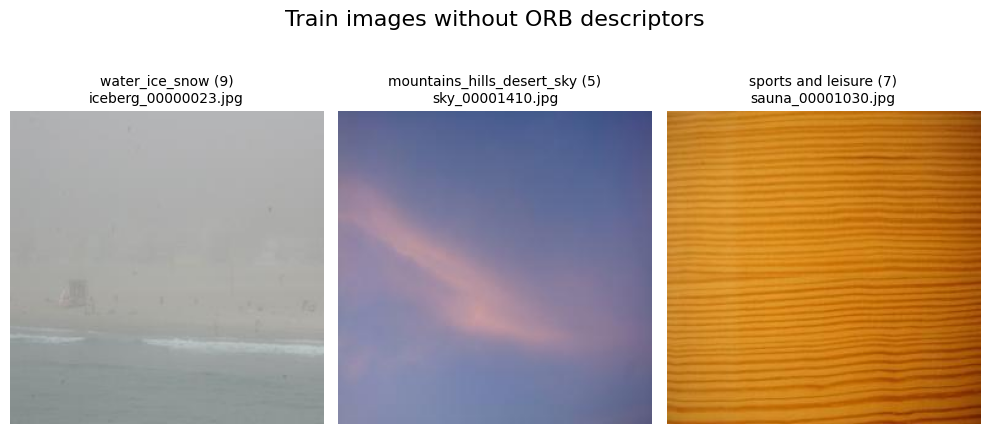

In [34]:
# Check which images failed to compute ORB descriptors
FAILED_PATHS = {
    "../data/places_reduced/train/water_ice_snow/iceberg_00000023.jpg",
    "../data/places_reduced/train/mountains_hills_desert_sky/sky_00001410.jpg",
    "../data/places_reduced/train/sports and leisure/sauna_00001030.jpg"
}

failed_images_for_plot: List[Tuple[Type[Image.Image], int]] = []

for img_pil, label in data_train:
    if hasattr(img_pil, 'filename') and img_pil.filename in FAILED_PATHS:
        failed_images_for_plot.append((img_pil, label))

if failed_images_for_plot:
    plot_images(
        failed_images_for_plot, 
        title="Train images without ORB descriptors",
        figsize=(10, 5),
        max_cols=3
    )

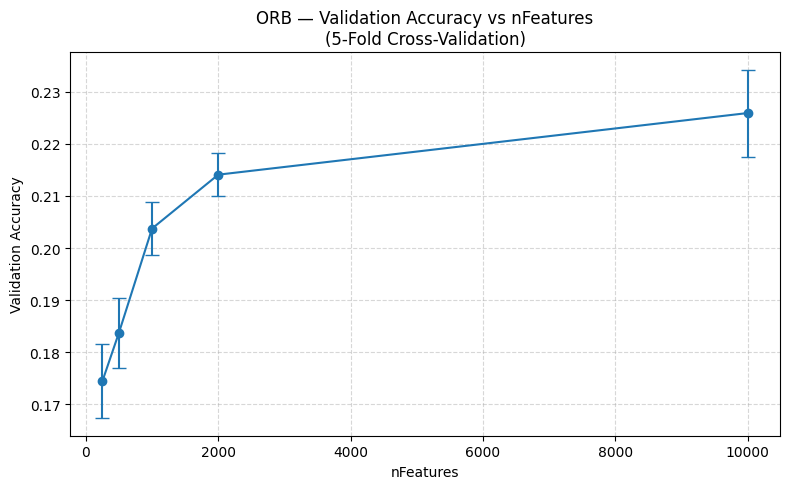

In [13]:
# Plot ORB Validation Accuracy vs nFeatures (5-Fold CV)

# Since the dataset is reasonably balanced and we use stratified 5-fold cross-validation, 
# accuracy is a reliable metric for evaluating performance in this experiment.
n_features = orb_nfeatures

# Accuracy
acc_means = [orb_results[n].val.accuracy.mean for n in n_features]
acc_stds  = [orb_results[n].val.accuracy.std for n in n_features]

plot_cv_accuracy(
    x_values=n_features,
    means=acc_means,
    stds=acc_stds,
    descriptor_name="ORB",
    hyperparam_name="nFeatures"
)


In [11]:
# Tested on the held-out test set using the best nFeatures selected by cross-validation (10000)
bovw_params = {
    "detector_type": "ORB",
    "codebook_size": 512,
    "detector_kwargs": {"nfeatures": 10000},
}

classifier_cls = LogisticRegression
classifier_params = {
    "max_iter": 1000,
    "class_weight": "balanced",
}
bovw = BOVW(**bovw_params)
classifier = classifier_cls(**classifier_params)
orb_bovw, orb_classifier = train(dataset=data_train, bovw=bovw, classifier=classifier)

orb_acc, orb_prec, orb_rec, orb_f1, orb_y_test, orb_y_pred, orb_y_score = test(dataset=data_test, bovw=orb_bovw, classifier=orb_classifier, return_predictions=True)

Phase [Training]: Extracting the descriptors: 100%|██████████| 8700/8700 [00:21<00:00, 412.78it/s]


Fitting the codebook
Computing the bovw histograms
Fitting the classifier
Accuracy on Phase[Train]: 0.3356329768885823
Precision on Phase[Train]: 0.34024857488012766
Recall on Phase[Train]: 0.3356329768885823
F1-Score on Phase[Train]: 0.33097291035189796


Phase [Eval]: Extracting the descriptors: 100%|██████████| 2200/2200 [00:05<00:00, 438.61it/s]


Computing the bovw histograms
predicting the values
Accuracy on Phase[Test]: 0.21363636363636362
Precision on Phase[Test]: 0.21294428137427732
Recall on Phase[Test]: 0.21363636363636362
F1-Score on Phase[Test]: 0.20821734881013054


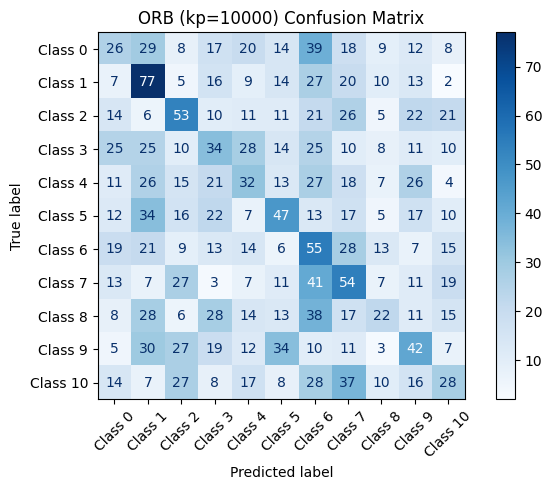

In [12]:
plot_confusion_matrix(orb_y_test, orb_y_pred, title="ORB (kp=10000) Confusion Matrix")

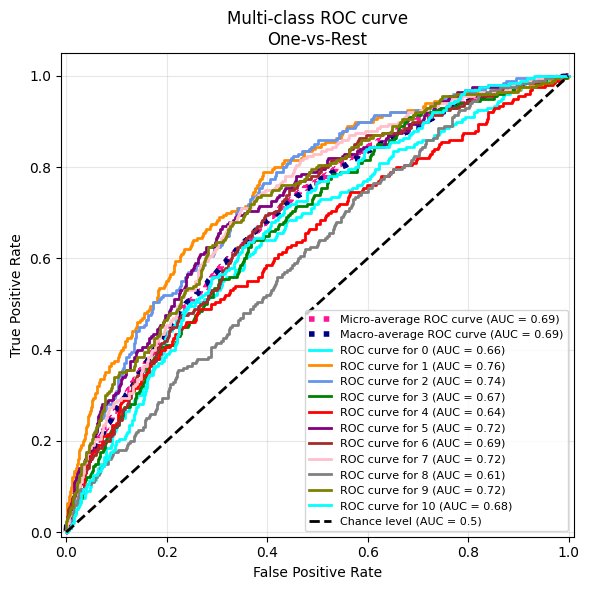


Micro-averaged One-vs-Rest ROC AUC score: 0.69
Macro-averaged One-vs-Rest ROC AUC score: 0.69

Per-class ROC AUC scores:
  0: 0.66
  1: 0.76
  2: 0.74
  3: 0.67
  4: 0.64
  5: 0.72
  6: 0.69
  7: 0.72
  8: 0.61
  9: 0.72
  10: 0.68


In [13]:
plot_multiclass_roc(orb_y_test, orb_y_score, figsize=(6,6))

### Comparison and Best Configuration

Comparing all three descriptors across different feature counts to select the best for further experimentation.

In [ ]:
# Comparison of all descriptors
print("SECTION A: FINAL COMPARISON - DESCRIPTORS AND NUMBER OF FEATURES")
print("-" * 80)

# Prepare comparison data
comparison_data = []

for nfeatures in sift_nfeatures:
    comparison_data.append({
        "Descriptor": "SIFT",
        "nfeatures": nfeatures,
        "Train Acc": sift_results[nfeatures].train.accuracy.mean,
        "Val Acc": sift_results[nfeatures].val.accuracy.mean,
        "Val Acc Std": sift_results[nfeatures].val.accuracy.std,
        "Val Prec": sift_results[nfeatures].val.precision.mean,
        "Val Rec": sift_results[nfeatures].val.recall.mean,
        "Val F1": sift_results[nfeatures].val.f1.mean,
    })

for threshold in akaze_thresholds:
    comparison_data.append({
        "Descriptor": "AKAZE",
        "nfeatures": threshold,
        "Train Acc": akaze_results[threshold].train.accuracy.mean,
        "Val Acc": akaze_results[threshold].val.accuracy.mean,
        "Val Acc Std": akaze_results[threshold].val.accuracy.std,
        "Val Prec": akaze_results[threshold].val.precision.mean,
        "Val Rec": akaze_results[threshold].val.recall.mean,
        "Val F1": akaze_results[threshold].val.f1.mean,
    })

for nfeatures in orb_nfeatures:
    comparison_data.append({
        "Descriptor": "ORB",
        "nfeatures": nfeatures,
        "Train Acc": orb_results[nfeatures].train.accuracy.mean,
        "Val Acc": orb_results[nfeatures].val.accuracy.mean,
        "Val Acc Std": orb_results[nfeatures].val.accuracy.std,
        "Val Prec": orb_results[nfeatures].val.precision.mean,
        "Val Rec": orb_results[nfeatures].val.recall.mean,
        "Val F1": orb_results[nfeatures].val.f1.mean,
    })

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

# Find best configuration
best_idx = comparison_df["Val Acc"].idxmax()
best_config = comparison_df.loc[best_idx]

print("\n" + "=" * 80)
print("BEST CONFIGURATION FOR SECTION A")
print("=" * 80)
print(f"Descriptor: {best_config['Descriptor']}")
print(f"Number of Features: {best_config['nfeatures']}")
print(f"Val Accuracy: {best_config['Val Acc']:.4f} ± {best_config['Val Acc Std']:.4f}")
print(f"Val Precision: {best_config['Val Prec']:.4f}")
print(f"Val Recall: {best_config['Val Rec']:.4f}")
print(f"Val F1-Score: {best_config['Val F1']:.4f}")

# Recommendation for next section
best_descriptor = best_config['Descriptor']
best_nfeatures = int(best_config['nfeatures'])
print(f"\nRecommendation for next sections: Use {best_descriptor} with nfeatures={best_nfeatures}")

SECTION A: FINAL COMPARISON - DESCRIPTORS AND NUMBER OF FEATURES
--------------------------------------------------------------------------------
Descriptor  nfeatures  Train Acc  Val Acc  Val Acc Std  Val Prec  Val Rec  Val F1
      SIFT   250.0000     0.4335   0.2899       0.0184    0.2791   0.2899  0.2814
      SIFT   500.0000     0.4431   0.3120       0.0203    0.3034   0.3120  0.3046
      SIFT  1000.0000     0.4510   0.3288       0.0216    0.3191   0.3288  0.3207
      SIFT  2000.0000     0.4477   0.3218       0.0111    0.3138   0.3218  0.3143
      SIFT 10000.0000     0.4508   0.3244       0.0160    0.3154   0.3244  0.3168
     AKAZE     0.0004     0.3678   0.2112       0.0093    0.2058   0.2112  0.2060
     AKAZE     0.0008     0.3630   0.1965       0.0079    0.1914   0.1965  0.1916
     AKAZE     0.0012     0.3510   0.1949       0.0060    0.1889   0.1949  0.1897
       ORB   250.0000     0.3394   0.1744       0.0071    0.1709   0.1744  0.1711
       ORB   500.0000     0.3425  

## B) Density vs Non Density (SIFT vs Dense SIFT)

Since SIFT was the best performing descriptor in the previous experiment, we now compare keypoint-based SIFT with Dense SIFT to evaluate whether dense sampling can improve scene recognition performance. In particular, we aim to answer:

* Does Dense SIFT outperform standard SIFT in this context?

* How does the step size (sampling density) affect performance and computation time?

* Does the scale used for descriptor extraction influence the results?

In this experiment, we first fix the descriptor scale and vary the step size to study the effect of sampling density. Then, we fix the "best" step size and evaluate different scales to analyze whether scale impacts performance. This allows us to isolate the influence of each factor and fairly assess the benefits of Dense SIFT over standard keypoint-based SIFT.

### Step Size Evaluation

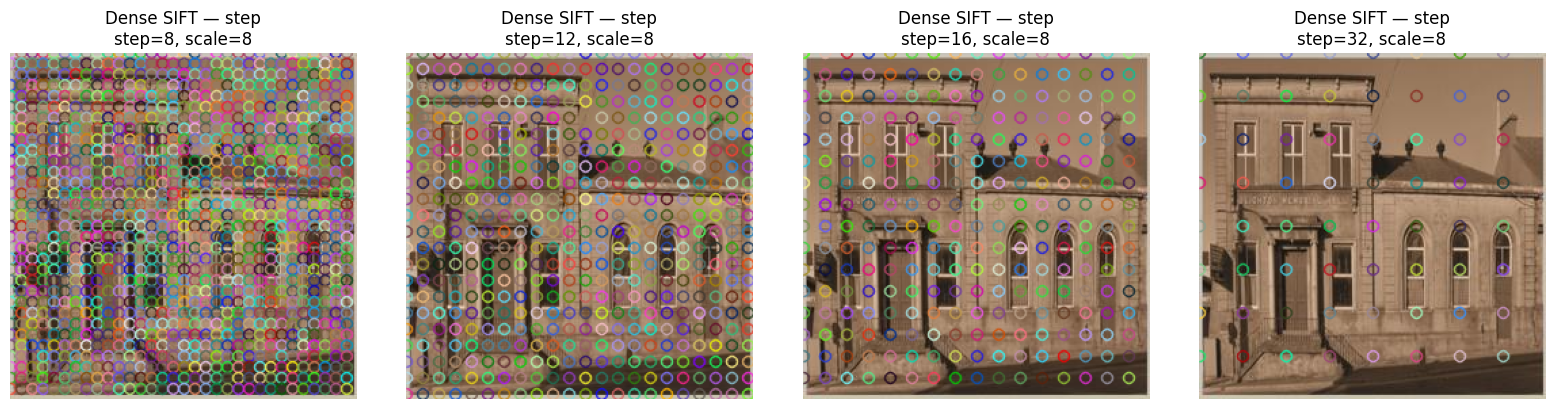

In [35]:
steps = [8, 12, 16, 32]
scale = 8

sample_idx = 70
img = np.array(data_train[sample_idx][0])

plt.figure(figsize=(16, 4))
for i, s in enumerate(steps, 1):
    plt.subplot(1, 4, i)
    show_dense_sift(img, step=s, scale=scale, title="Dense SIFT — step")
plt.tight_layout()
plt.show()


In [36]:
# DENSE SIFT — STEP SIZE EXPERIMENT
print("TESTING DENSE SIFT (VARYING STEP SIZE)")

dense_steps = [8, 12, 16, 32]   
dense_scale = 8            
dense_results = {}

for step in dense_steps:
    print(f"\nDense SIFT with step={step}, scale={dense_scale}")
    
    bovw_params = {
        "detector_type": "DSIFT",          
        "codebook_size": 512,
        "dense_kwargs": {
            "step": step,
            "scale": dense_scale,
        },
    }
    
    classifier_cls = LogisticRegression
    classifier_params = {
        "max_iter": 1000,
        "class_weight": "balanced",
    }
    
    scores = cross_validate_bovw(
        data_train,
        bovw_kwargs=bovw_params,
        classifier_cls=classifier_cls,
        classifier_kwargs=classifier_params,
        n_splits=5,
        verbose=False,
    )
    
    dense_results[step] = scores
    
    print(f"[Dense SIFT step={step}] Results:")
    print(f"  Train Accuracy:  {scores.train.accuracy.mean:.4f} ± {scores.train.accuracy.std:.4f}")
    print(f"  Val Accuracy:   {scores.val.accuracy.mean:.4f} ± {scores.val.accuracy.std:.4f}")
    print(f"  Val Precision:  {scores.val.precision.mean:.4f} ± {scores.val.precision.std:.4f}")
    print(f"  Val Recall:     {scores.val.recall.mean:.4f} ± {scores.val.recall.std:.4f}")
    print(f"  Val F1-Score:   {scores.val.f1.mean:.4f} ± {scores.val.f1.std:.4f}")

print("\nDENSE SIFT (STEP) SUMMARY")
for step in dense_steps:
    print(f"step={step:2d} -> Accuracy Train: {dense_results[step].train.accuracy.mean:.4f} ± {dense_results[step].train.accuracy.std:.4f}")
    print(f"step={step:2d} -> Accuracy Val:  {dense_results[step].val.accuracy.mean:.4f} ± {dense_results[step].val.accuracy.std:.4f}")
    print("")


TESTING DENSE SIFT (VARYING STEP SIZE)

Dense SIFT with step=8, scale=8


100%|██████████| 5/5 [05:17<00:00, 63.50s/it]


[Dense SIFT step=8] Results:
  Train Accuracy:  0.4181 ± 0.0026
  Val Accuracy:   0.3230 ± 0.0063
  Val Precision:  0.3142 ± 0.0074
  Val Recall:     0.3230 ± 0.0063
  Val F1-Score:   0.3131 ± 0.0067

Dense SIFT with step=12, scale=8


100%|██████████| 5/5 [03:35<00:00, 43.09s/it]


[Dense SIFT step=12] Results:
  Train Accuracy:  0.4248 ± 0.0026
  Val Accuracy:   0.2972 ± 0.0046
  Val Precision:  0.2880 ± 0.0053
  Val Recall:     0.2972 ± 0.0046
  Val F1-Score:   0.2882 ± 0.0045

Dense SIFT with step=16, scale=8


100%|██████████| 5/5 [02:32<00:00, 30.58s/it]


[Dense SIFT step=16] Results:
  Train Accuracy:  0.4240 ± 0.0029
  Val Accuracy:   0.2816 ± 0.0051
  Val Precision:  0.2718 ± 0.0051
  Val Recall:     0.2816 ± 0.0051
  Val F1-Score:   0.2723 ± 0.0046

Dense SIFT with step=32, scale=8


100%|██████████| 5/5 [01:12<00:00, 14.52s/it]

[Dense SIFT step=32] Results:
  Train Accuracy:  0.3964 ± 0.0031
  Val Accuracy:   0.2278 ± 0.0077
  Val Precision:  0.2184 ± 0.0073
  Val Recall:     0.2278 ± 0.0077
  Val F1-Score:   0.2200 ± 0.0078

DENSE SIFT (STEP) SUMMARY
step= 8 -> Accuracy Train: 0.4181 ± 0.0026
step= 8 -> Accuracy Val:  0.3230 ± 0.0063

step=12 -> Accuracy Train: 0.4248 ± 0.0026
step=12 -> Accuracy Val:  0.2972 ± 0.0046

step=16 -> Accuracy Train: 0.4240 ± 0.0029
step=16 -> Accuracy Val:  0.2816 ± 0.0051

step=32 -> Accuracy Train: 0.3964 ± 0.0031
step=32 -> Accuracy Val:  0.2278 ± 0.0077



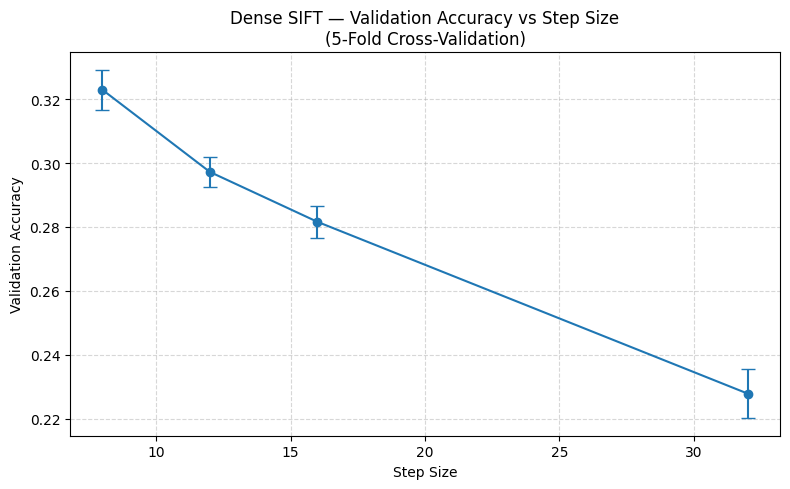

In [37]:
# Plot Dense SIFT Validation Accuracy vs Step Size (5-Fold CV)
fixed_scale = 8

dense_steps = [8, 12, 16, 32]  

acc_means = [dense_results[s].val.accuracy.mean for s in dense_steps]
acc_stds  = [dense_results[s].val.accuracy.std  for s in dense_steps]

plot_cv_accuracy(
    x_values=dense_steps,
    means=acc_means,
    stds=acc_stds,
    descriptor_name="Dense SIFT",
    hyperparam_name="Step Size"
)

### Scale Size Evaluation

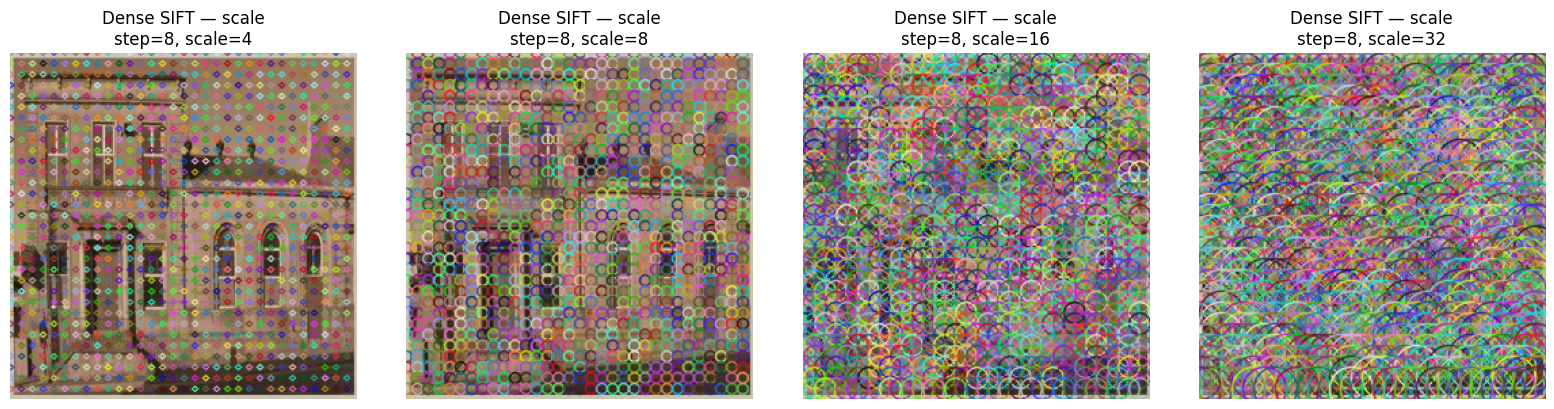

In [38]:
step = 8
scales = [4, 8, 16, 32]

sample_idx = 70
img = np.array(data_train[sample_idx][0])

plt.figure(figsize=(16, 4))
for i, sc in enumerate(scales, 1):
    plt.subplot(1, 4, i)
    show_dense_sift(img, step=step, scale=sc, title="Dense SIFT — scale")
plt.tight_layout()
plt.show()

In [ ]:
# DENSE SIFT — SCALE SIZE EXPERIMENT
print("TESTING DENSE SIFT (VARYING SCALE SIZE)")

dense_step = 8   
dense_scales = [4, 8, 16, 32]            
dense_results = {}

for scale in dense_scales:
    print(f"\nDense SIFT with step={dense_step}, scale={scale}")
    
    bovw_params = {
        "detector_type": "DSIFT",          
        "codebook_size": 512,
        "dense_kwargs": {
            "step": dense_step,
            "scale": scale,
        },
    }
    
    classifier_cls = LogisticRegression
    classifier_params = {
        "max_iter": 1000,
        "class_weight": "balanced",
    }
    
    scores = cross_validate_bovw(
        data_train,
        bovw_kwargs=bovw_params,
        classifier_cls=classifier_cls,
        classifier_kwargs=classifier_params,
        n_splits=5,
        verbose=False,
    )
    
    dense_results[scale] = scores
    
    print(f"[Dense SIFT step={dense_step}, scale={scale}] Results:")
    print(f"  Train Accuracy:  {scores.train.accuracy.mean:.4f} ± {scores.train.accuracy.std:.4f}")
    print(f"  Val Accuracy:   {scores.val.accuracy.mean:.4f} ± {scores.val.accuracy.std:.4f}")
    print(f"  Val Precision:  {scores.val.precision.mean:.4f} ± {scores.val.precision.std:.4f}")
    print(f"  Val Recall:     {scores.val.recall.mean:.4f} ± {scores.val.recall.std:.4f}")
    print(f"  Val F1-Score:   {scores.val.f1.mean:.4f} ± {scores.val.f1.std:.4f}")

print("\nDENSE SIFT (SCALE) SUMMARY")
for scale in dense_scales:
    print(f"scale={scale:2d} -> Accuracy Train: {dense_results[scale].train.accuracy.mean:.4f} ± {dense_results[scale].train.accuracy.std:.4f}")
    print(f"scale={scale:2d} -> Accuracy Val:  {dense_results[scale].val.accuracy.mean:.4f} ± {dense_results[scale].val.accuracy.std:.4f}")
    print("")


TESTING DENSE SIFT (VARYING SCALE SIZE)

Dense SIFT with step=8, scale=4


100%|██████████| 5/5 [05:22<00:00, 64.46s/it]


[Dense SIFT step=8, scale=4] Results:
  Train Accuracy:  0.4195 ± 0.0018
  Val Accuracy:   0.3251 ± 0.0070
  Val Precision:  0.3182 ± 0.0056
  Val Recall:     0.3251 ± 0.0070
  Val F1-Score:   0.3161 ± 0.0063

Dense SIFT with step=8, scale=8


100%|██████████| 5/5 [04:38<00:00, 55.67s/it]


[Dense SIFT step=8, scale=8] Results:
  Train Accuracy:  0.4211 ± 0.0041
  Val Accuracy:   0.3276 ± 0.0110
  Val Precision:  0.3197 ± 0.0118
  Val Recall:     0.3276 ± 0.0110
  Val F1-Score:   0.3184 ± 0.0114

Dense SIFT with step=8, scale=16


100%|██████████| 5/5 [04:47<00:00, 57.55s/it]


[Dense SIFT step=8, scale=16] Results:
  Train Accuracy:  0.4219 ± 0.0017
  Val Accuracy:   0.3261 ± 0.0019
  Val Precision:  0.3185 ± 0.0028
  Val Recall:     0.3261 ± 0.0019
  Val F1-Score:   0.3167 ± 0.0027

Dense SIFT with step=8, scale=32


100%|██████████| 5/5 [04:39<00:00, 55.88s/it]

[Dense SIFT step=8, scale=32] Results:
  Train Accuracy:  0.4206 ± 0.0050
  Val Accuracy:   0.3286 ± 0.0099
  Val Precision:  0.3204 ± 0.0111
  Val Recall:     0.3286 ± 0.0099
  Val F1-Score:   0.3192 ± 0.0099

DENSE SIFT (SCALE) SUMMARY
scale= 4 -> Accuracy Train: 0.4195 ± 0.0018
scale= 4 -> Accuracy Val:  0.3251 ± 0.0070

scale= 8 -> Accuracy Train: 0.4211 ± 0.0041
scale= 8 -> Accuracy Val:  0.3276 ± 0.0110

scale=16 -> Accuracy Train: 0.4219 ± 0.0017
scale=16 -> Accuracy Val:  0.3261 ± 0.0019

scale=32 -> Accuracy Train: 0.4206 ± 0.0050
scale=32 -> Accuracy Val:  0.3286 ± 0.0099



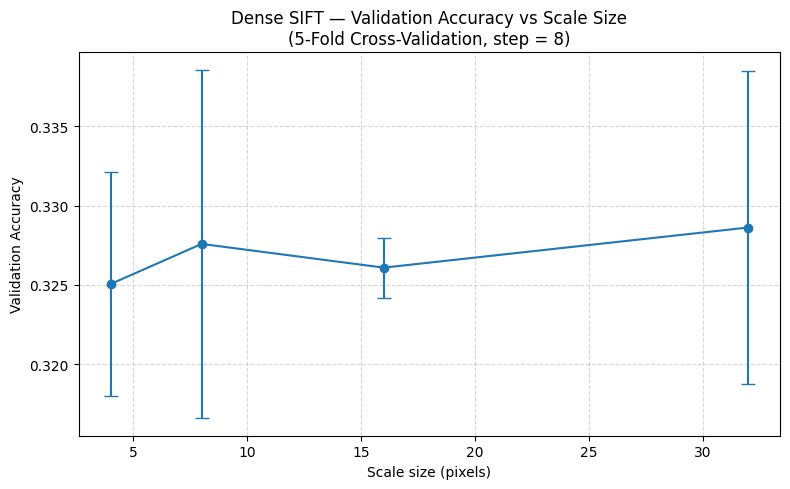

In [41]:
# Plot Dense SIFT Validation Accuracy vs Scale Size (5-Fold CV)

fixed_step = 8

dense_scales = [4, 8, 16, 32]  

# Accuracy (CV test)
acc_means = [dense_results[s].val.accuracy.mean for s in dense_scales]
acc_stds  = [dense_results[s].val.accuracy.std  for s in dense_scales]

plt.figure(figsize=(8, 5))
plt.errorbar(dense_scales, acc_means, yerr=acc_stds,
             marker='o', capsize=5)

plt.title(f"Dense SIFT — Validation Accuracy vs Scale Size\n(5-Fold Cross-Validation, step = {fixed_step})")
plt.xlabel("Scale size (pixels)")
plt.ylabel("Validation Accuracy")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


In [18]:
# Tested on the held-out test set using the best step and scale selected by cross-validation (step=8, scale=32)
bovw_params = {
    "detector_type": "DSIFT",
    "codebook_size": 512,
    "dense_kwargs": {"step": 8, "scale": 32},
}

classifier_cls = LogisticRegression
classifier_params = {
    "max_iter": 1000,
    "class_weight": "balanced",
}
bovw = BOVW(**bovw_params)
classifier = classifier_cls(**classifier_params)
dsift_bovw, dsift_classifier = train(dataset=data_train, bovw=bovw, classifier=classifier)

dsift_acc, dsift_prec, dsift_rec, dsift_f1, dsift_y_test, dsift_y_pred, dsift_y_score = test(dataset=data_test, bovw=dsift_bovw, classifier=dsift_classifier, return_predictions=True)

Phase [Training]: Extracting the descriptors: 100%|██████████| 8700/8700 [00:16<00:00, 541.28it/s]


Fitting the codebook
Computing the bovw histograms
Fitting the classifier
Accuracy on Phase[Train]: 0.41367816091954024
Precision on Phase[Train]: 0.4108867024805957
Recall on Phase[Train]: 0.41367816091954024
F1-Score on Phase[Train]: 0.40691689982995005


Phase [Eval]: Extracting the descriptors: 100%|██████████| 2200/2200 [00:03<00:00, 558.23it/s]


Computing the bovw histograms
predicting the values
Accuracy on Phase[Test]: 0.31136363636363634
Precision on Phase[Test]: 0.2987225017749022
Recall on Phase[Test]: 0.31136363636363634
F1-Score on Phase[Test]: 0.29956552744347714


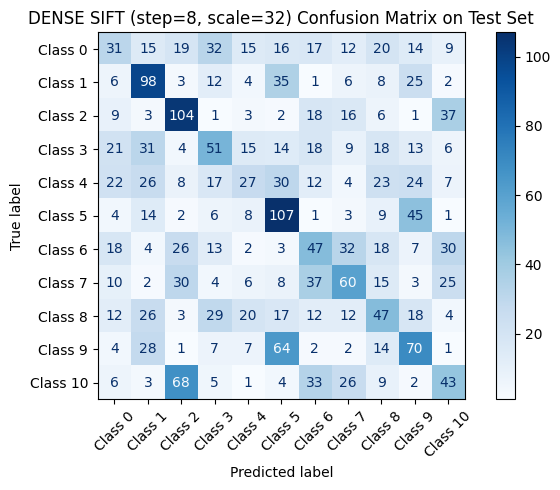

In [19]:
plot_confusion_matrix(dsift_y_test, dsift_y_pred, title="DENSE SIFT (step=8, scale=32) Confusion Matrix on Test Set")  

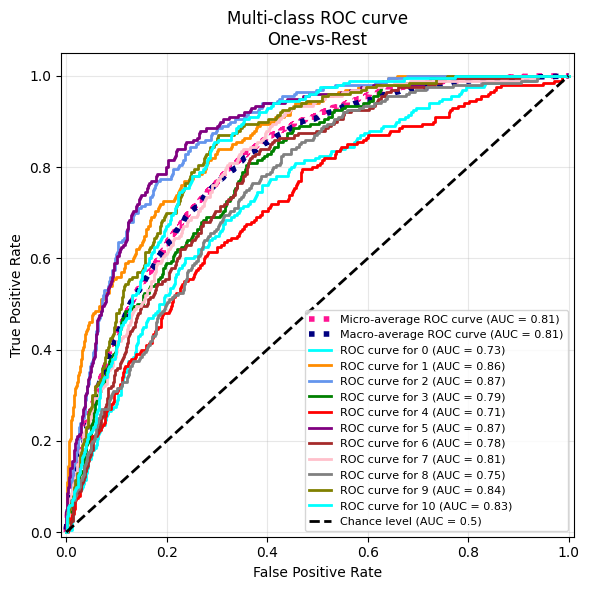


Micro-averaged One-vs-Rest ROC AUC score: 0.81
Macro-averaged One-vs-Rest ROC AUC score: 0.81

Per-class ROC AUC scores:
  0: 0.73
  1: 0.86
  2: 0.87
  3: 0.79
  4: 0.71
  5: 0.87
  6: 0.78
  7: 0.81
  8: 0.75
  9: 0.84
  10: 0.83


In [20]:
plot_multiclass_roc(dsift_y_test, dsift_y_score, figsize=(6,6))

SECTION B: FINAL COMPARISON - SIFT vs DENSE SIFT


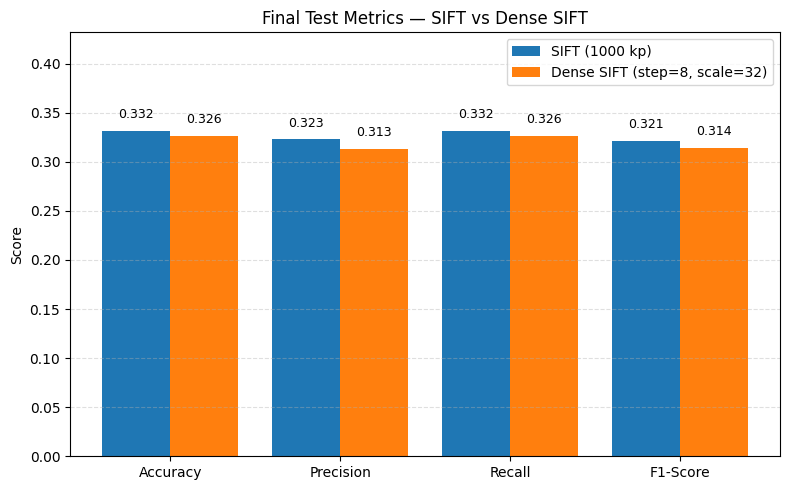

In [48]:
# Final Comparison: SIFT vs Dense SIFT in our test data
print("SECTION B: FINAL COMPARISON - SIFT vs DENSE SIFT")
sift_metrics = {
    "Accuracy": sift_acc,
    "Precision": sift_prec,
    "Recall": sift_rec,
    "F1-Score": sift_f1
}

dense_metrics = {
    "Accuracy": dsift_acc,  
    "Precision": dsift_prec,
    "Recall": dsift_rec,
    "F1-Score": dsift_f1
}

plot_final_metrics_comparison(
    method_names=["SIFT (1000 kp)", "Dense SIFT (step=8, scale=32)"],
    metrics_list=[sift_metrics, dense_metrics],
    title="Final Test Metrics — SIFT vs Dense SIFT"
)


We will still work with SIFT (kp=100)

## C) Size of codebook

In this experiment, we investigate how the size of the visual vocabulary (codebook) influences the performance of the Bag-of-Words representation for scene recognition. The number of visual words, k, determines the granularity of feature quantization and, therefore, directly affects both discriminative capability and computational cost. We aim to answer the following research questions:

- How does increasing the codebook size impact classification accuracy?

- Is there a point of diminishing returns where larger codebooks no longer improve performance?

- How does codebook size affect computation time?

In [15]:
size_results = {}

for size in [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048]:
    bovw_params = {
        "detector_type": "SIFT",
        "codebook_size": size,
        "detector_kwargs": {"nfeatures": 1000},
    }
    
    classifier_cls = LogisticRegression
    classifier_params = {
        "max_iter": 1000,
        "class_weight": "balanced",
    }
    
    scores = cross_validate_bovw(
        dataset=data_train,
            bovw_kwargs=bovw_params,
            classifier_cls=classifier_cls,
            classifier_kwargs=classifier_params,
            n_splits=5
    )
        
    size_results[size] = scores


print("\nSIFT SUMMARY")
for size in size_results.keys():
    print(f"codebook_size={size} -> Accuracy Train: {size_results[size].train.accuracy.mean:.4f} ± {size_results[size].train.accuracy.std:.4f}")
    print(f"codebook_size={size} -> Accuracy Val: {size_results[size].val.accuracy.mean:.4f} ± {size_results[size].val.accuracy.std:.4f}")
    print()

Phase [Setup]: Extracting the descriptors:   8%|▊         | 692/8700 [00:00<00:04, 1627.12it/s]

Could not compute descriptors for image ../data/places_reduced/train/water_ice_snow/iceberg_00000023.jpg of class 9.


Phase [Setup]: Extracting the descriptors:  15%|█▌        | 1341/8700 [00:00<00:04, 1542.12it/s]

Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/sky_00001410.jpg of class 5.


  0%|          | 0/5 [00:00<?, ?it/s]/home/loreoregi/Desktop/Computer Vision/C3/Project/project-team-6/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/loreoregi/Desktop/Computer Vision/C3/Project/project-team-6/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
 20%|██        | 1/5 [00:04<00:17,  4.26s/it]/home/loreoregi/Desktop/Computer Vision/C3/Project/project-team-6/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMet

Could not compute descriptors for image ../data/places_reduced/train/water_ice_snow/iceberg_00000023.jpg of class 9.


Phase [Setup]: Extracting the descriptors:  14%|█▍        | 1207/8700 [00:00<00:04, 1506.23it/s]

Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/sky_00001410.jpg of class 5.


 40%|████      | 2/5 [00:06<00:08,  2.99s/it]/home/loreoregi/Desktop/Computer Vision/C3/Project/project-team-6/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/loreoregi/Desktop/Computer Vision/C3/Project/project-team-6/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
 60%|██████    | 3/5 [00:09<00:06,  3.03s/it]/home/loreoregi/Desktop/Computer Vision/C3/Project/project-team-6/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: Unde

Could not compute descriptors for image ../data/places_reduced/train/water_ice_snow/iceberg_00000023.jpg of class 9.


Phase [Setup]: Extracting the descriptors:  14%|█▍        | 1246/8700 [00:00<00:04, 1739.84it/s]

Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/sky_00001410.jpg of class 5.


Phase [Setup]: Extracting the descriptors:  10%|▉         | 850/8700 [00:00<00:04, 1737.72it/s]

Could not compute descriptors for image ../data/places_reduced/train/water_ice_snow/iceberg_00000023.jpg of class 9.


Phase [Setup]: Extracting the descriptors:  16%|█▌        | 1376/8700 [00:00<00:04, 1735.46it/s]

Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/sky_00001410.jpg of class 5.


Phase [Setup]: Extracting the descriptors:   8%|▊         | 708/8700 [00:00<00:04, 1740.74it/s]

Could not compute descriptors for image ../data/places_reduced/train/water_ice_snow/iceberg_00000023.jpg of class 9.


Phase [Setup]: Extracting the descriptors:  14%|█▍        | 1247/8700 [00:00<00:04, 1735.11it/s]

Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/sky_00001410.jpg of class 5.


Phase [Setup]: Extracting the descriptors:  10%|▉         | 859/8700 [00:00<00:04, 1733.36it/s]

Could not compute descriptors for image ../data/places_reduced/train/water_ice_snow/iceberg_00000023.jpg of class 9.


Phase [Setup]: Extracting the descriptors:  14%|█▍        | 1202/8700 [00:00<00:04, 1650.74it/s]

Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/sky_00001410.jpg of class 5.


Phase [Setup]: Extracting the descriptors:   8%|▊         | 716/8700 [00:00<00:04, 1748.81it/s]

Could not compute descriptors for image ../data/places_reduced/train/water_ice_snow/iceberg_00000023.jpg of class 9.


Phase [Setup]: Extracting the descriptors:  14%|█▍        | 1259/8700 [00:00<00:04, 1739.92it/s]

Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/sky_00001410.jpg of class 5.


Phase [Setup]: Extracting the descriptors:  10%|▉         | 829/8700 [00:00<00:04, 1708.57it/s]

Could not compute descriptors for image ../data/places_reduced/train/water_ice_snow/iceberg_00000023.jpg of class 9.


Phase [Setup]: Extracting the descriptors:  16%|█▌        | 1353/8700 [00:00<00:04, 1731.69it/s]

Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/sky_00001410.jpg of class 5.


Phase [Setup]: Extracting the descriptors:  10%|▉         | 853/8700 [00:00<00:04, 1741.45it/s]

Could not compute descriptors for image ../data/places_reduced/train/water_ice_snow/iceberg_00000023.jpg of class 9.


Phase [Setup]: Extracting the descriptors:  14%|█▍        | 1198/8700 [00:00<00:04, 1670.73it/s]

Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/sky_00001410.jpg of class 5.


Phase [Setup]: Extracting the descriptors:  10%|▉         | 867/8700 [00:00<00:04, 1766.12it/s]

Could not compute descriptors for image ../data/places_reduced/train/water_ice_snow/iceberg_00000023.jpg of class 9.


Phase [Setup]: Extracting the descriptors:  14%|█▍        | 1224/8700 [00:00<00:04, 1720.55it/s]

Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/sky_00001410.jpg of class 5.


Phase [Setup]: Extracting the descriptors:  10%|▉         | 835/8700 [00:00<00:04, 1721.02it/s]

Could not compute descriptors for image ../data/places_reduced/train/water_ice_snow/iceberg_00000023.jpg of class 9.


Phase [Setup]: Extracting the descriptors:  16%|█▌        | 1356/8700 [00:00<00:04, 1716.72it/s]

Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/sky_00001410.jpg of class 5.


100%|██████████| 5/5 [04:26<00:00, 53.32s/it]


SIFT SUMMARY
codebook_size=2 -> Accuracy Train: 0.1254 ± 0.0132
codebook_size=2 -> Accuracy Val: 0.1292 ± 0.0200

codebook_size=4 -> Accuracy Train: 0.1822 ± 0.0130
codebook_size=4 -> Accuracy Val: 0.1841 ± 0.0111

codebook_size=8 -> Accuracy Train: 0.2149 ± 0.0127
codebook_size=8 -> Accuracy Val: 0.2140 ± 0.0133

codebook_size=16 -> Accuracy Train: 0.2519 ± 0.0074
codebook_size=16 -> Accuracy Val: 0.2441 ± 0.0087

codebook_size=32 -> Accuracy Train: 0.2878 ± 0.0062
codebook_size=32 -> Accuracy Val: 0.2735 ± 0.0068

codebook_size=64 -> Accuracy Train: 0.3239 ± 0.0028
codebook_size=64 -> Accuracy Val: 0.2966 ± 0.0104

codebook_size=128 -> Accuracy Train: 0.3566 ± 0.0058
codebook_size=128 -> Accuracy Val: 0.3132 ± 0.0031

codebook_size=256 -> Accuracy Train: 0.4026 ± 0.0061
codebook_size=256 -> Accuracy Val: 0.3200 ± 0.0077

codebook_size=512 -> Accuracy Train: 0.4534 ± 0.0036
codebook_size=512 -> Accuracy Val: 0.3325 ± 0.0078

codebook_size=1024 -> Accuracy Train: 0.5039 ± 0.0034
codeb

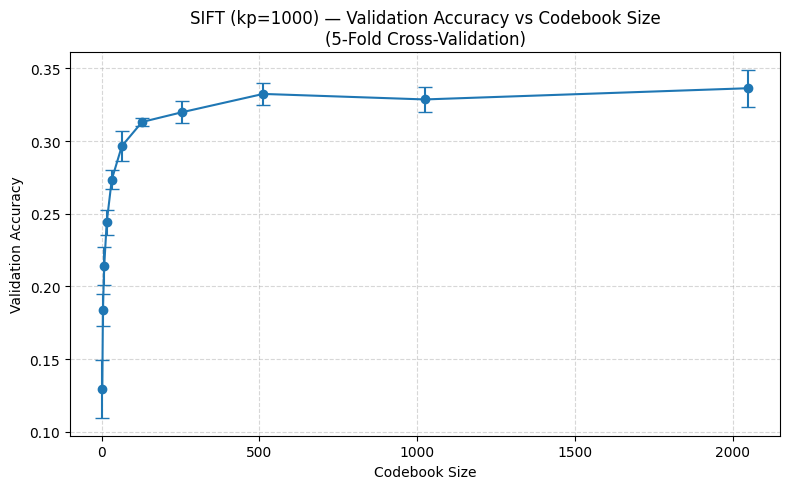

In [16]:
# Plot SIFT (kp=1000) Validation Accuracy vs Codebook Size (5-Fold CV)

# Since the dataset is reasonably balanced and we use stratified 5-fold cross-validation, 
# accuracy is a reliable metric for evaluating performance in this experiment.

k_codebook = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048]

acc_means = [size_results[k].val.accuracy.mean for k in k_codebook]
acc_stds  = [size_results[k].val.accuracy.std for k in k_codebook]

plot_cv_accuracy(
    x_values=k_codebook,
    means=acc_means,
    stds=acc_stds,
    descriptor_name="SIFT (kp=1000)",
    hyperparam_name="Codebook Size"
)


In [21]:
# Tested on the held-out test set using the best codebook size selected by cross-validation (2048)
bovw_params = {
    "detector_type": "SIFT",
    "codebook_size": 2048,
    "detector_kwargs": {"nfeatures": 1000},
}

classifier_cls = LogisticRegression
classifier_params = {
    "max_iter": 1000,
    "class_weight": "balanced",
}
bovw = BOVW(**bovw_params)
classifier = classifier_cls(**classifier_params)
sift_2048_bovw, sift_2048_classifier = train(dataset=data_train, bovw=bovw, classifier=classifier)

sift_acc_2048, sift_prec_2048, sift_rec_2048, sift_f1_2048, sift_y_test_2048, sift_y_pred_2048, sift_y_score_2048 = test(dataset=data_test, bovw=sift_2048_bovw, classifier=sift_2048_classifier, return_predictions=True)

Phase [Training]: Extracting the descriptors: 100%|██████████| 8700/8700 [00:12<00:00, 723.72it/s]


Fitting the codebook
Computing the bovw histograms
Fitting the classifier
Accuracy on Phase[Train]: 0.5473672108530697
Precision on Phase[Train]: 0.5467161254741641
Recall on Phase[Train]: 0.5473672108530697
F1-Score on Phase[Train]: 0.5435197660379997


Phase [Eval]: Extracting the descriptors: 100%|██████████| 2200/2200 [00:02<00:00, 1092.03it/s]


Computing the bovw histograms
predicting the values
Accuracy on Phase[Test]: 0.3431818181818182
Precision on Phase[Test]: 0.3344372388669758
Recall on Phase[Test]: 0.3431818181818182
F1-Score on Phase[Test]: 0.33332176160331883


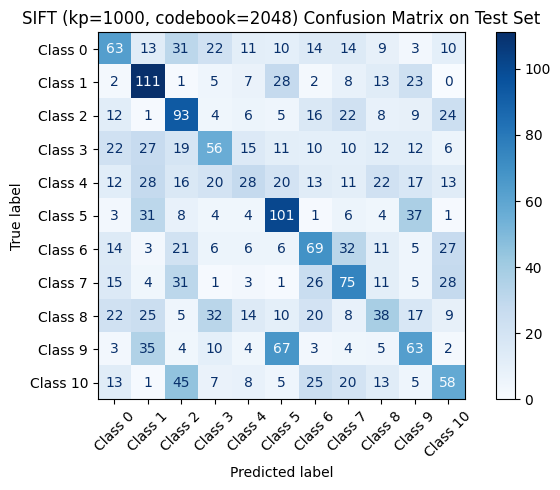

In [22]:
plot_confusion_matrix(sift_y_test_2048, sift_y_pred_2048, title="SIFT (kp=1000, codebook=2048) Confusion Matrix on Test Set")

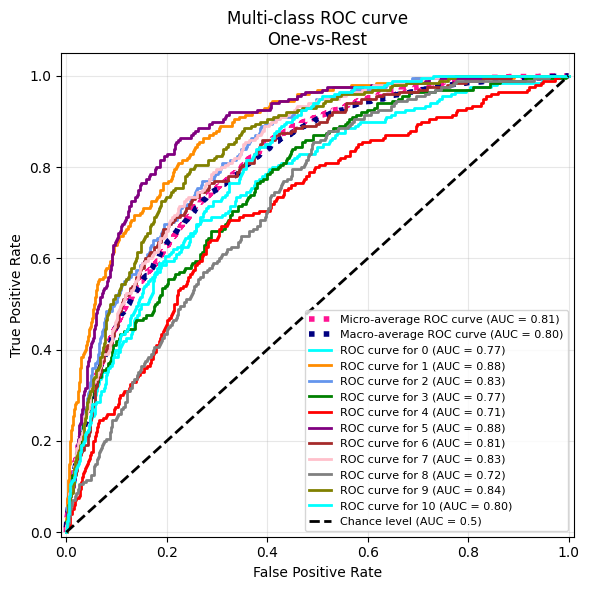


Micro-averaged One-vs-Rest ROC AUC score: 0.81
Macro-averaged One-vs-Rest ROC AUC score: 0.80

Per-class ROC AUC scores:
  0: 0.77
  1: 0.88
  2: 0.83
  3: 0.77
  4: 0.71
  5: 0.88
  6: 0.81
  7: 0.83
  8: 0.72
  9: 0.84
  10: 0.80


In [23]:
plot_multiclass_roc(sift_y_test_2048, sift_y_score_2048, figsize=(6,6))

## D) Spatial Pyramids

In this experiment, we investigate how spatial pyramids influence the performance of the Bag-of-Words representation for image classification. Spatial pyramids capture the spatial distribution of visual words at multiple scales, which can be particularly useful for scene understanding. We aim to answer the following research questions:

- How does adding spatial information through pyramid levels improve classification accuracy?

- Is there an optimal number of pyramid levels that balances discriminative power with computational cost?

- Does the spatial structure of visual words in natural scenes provide significant benefits for scene recognition?

We will test pyramid levels from 1 (no pyramid) to 5, keeping the SIFT descriptor with 1000 keypoints and a codebook size of 512.

In [7]:
pyramid_results = {}

for level in range(1, 6):
    bovw_params = {
        "detector_type": "SIFT",
        "codebook_size": 512,
        "pyramid_levels": level,
        "detector_kwargs": {"nfeatures": 1000},
    }
    
    classifier_cls = LogisticRegression
    classifier_params = {
        "max_iter": 1000,
        "class_weight": "balanced",
    }
    
    scores = cross_validate_bovw(
        dataset=data_train,
        bovw_kwargs=bovw_params,
        classifier_cls=classifier_cls,
        classifier_kwargs=classifier_params,
        n_splits=5
    )
        
    pyramid_results[level] = scores


print("\nSPATIAL PYRAMIDS SUMMARY")
for level in pyramid_results.keys():
    print(f"pyramid_level={level} -> Accuracy Train: {pyramid_results[level].train.accuracy.mean:.4f} ± {pyramid_results[level].train.accuracy.std:.4f}")
    print(f"pyramid_level={level} -> Accuracy Val: {pyramid_results[level].val.accuracy.mean:.4f} ± {pyramid_results[level].val.accuracy.std:.4f}")
    print()

Phase [Setup]: Extracting the descriptors:   6%|▌         | 489/8700 [00:05<01:23, 98.85it/s] 

Could not compute descriptors for image ../data/places_reduced/train\water_ice_snow\iceberg_00000023.jpg of class 9.


Phase [Setup]: Extracting the descriptors:  58%|█████▊    | 5083/8700 [00:52<00:36, 99.67it/s] 

Could not compute descriptors for image ../data/places_reduced/train\mountains_hills_desert_sky\sky_00001410.jpg of class 5.


Phase [Setup]: Extracting the descriptors:   6%|▌         | 518/8700 [00:01<00:16, 501.26it/s]

Could not compute descriptors for image ../data/places_reduced/train\water_ice_snow\iceberg_00000023.jpg of class 9.


Phase [Setup]: Extracting the descriptors:  59%|█████▉    | 5134/8700 [00:09<00:07, 503.60it/s]

Could not compute descriptors for image ../data/places_reduced/train\mountains_hills_desert_sky\sky_00001410.jpg of class 5.


Phase [Setup]: Extracting the descriptors:   6%|▌         | 540/8700 [00:01<00:15, 532.40it/s]

Could not compute descriptors for image ../data/places_reduced/train\water_ice_snow\iceberg_00000023.jpg of class 9.


Phase [Setup]: Extracting the descriptors:  59%|█████▉    | 5161/8700 [00:09<00:04, 720.26it/s]

Could not compute descriptors for image ../data/places_reduced/train\mountains_hills_desert_sky\sky_00001410.jpg of class 5.


Phase [Setup]: Extracting the descriptors:   6%|▌         | 530/8700 [00:01<00:15, 525.16it/s]

Could not compute descriptors for image ../data/places_reduced/train\water_ice_snow\iceberg_00000023.jpg of class 9.


Phase [Setup]: Extracting the descriptors:  60%|█████▉    | 5201/8700 [00:07<00:04, 783.37it/s]

Could not compute descriptors for image ../data/places_reduced/train\mountains_hills_desert_sky\sky_00001410.jpg of class 5.


Phase [Setup]: Extracting the descriptors:   6%|▌         | 538/8700 [00:01<00:15, 536.50it/s]

Could not compute descriptors for image ../data/places_reduced/train\water_ice_snow\iceberg_00000023.jpg of class 9.


Phase [Setup]: Extracting the descriptors:  59%|█████▉    | 5142/8700 [00:09<00:06, 558.72it/s]

Could not compute descriptors for image ../data/places_reduced/train\mountains_hills_desert_sky\sky_00001410.jpg of class 5.


100%|██████████| 5/5 [06:37<00:00, 79.57s/it]




SPATIAL PYRAMIDS SUMMARY
pyramid_level=1 -> Accuracy Train: 0.4514 ± 0.0035
pyramid_level=1 -> Accuracy Val: 0.3271 ± 0.0140

pyramid_level=2 -> Accuracy Train: 0.7840 ± 0.0049
pyramid_level=2 -> Accuracy Val: 0.3109 ± 0.0108

pyramid_level=3 -> Accuracy Train: 0.9977 ± 0.0008
pyramid_level=3 -> Accuracy Val: 0.3079 ± 0.0071

pyramid_level=4 -> Accuracy Train: 1.0000 ± 0.0001
pyramid_level=4 -> Accuracy Val: 0.3109 ± 0.0118

pyramid_level=5 -> Accuracy Train: 1.0000 ± 0.0000
pyramid_level=5 -> Accuracy Val: 0.3162 ± 0.0097



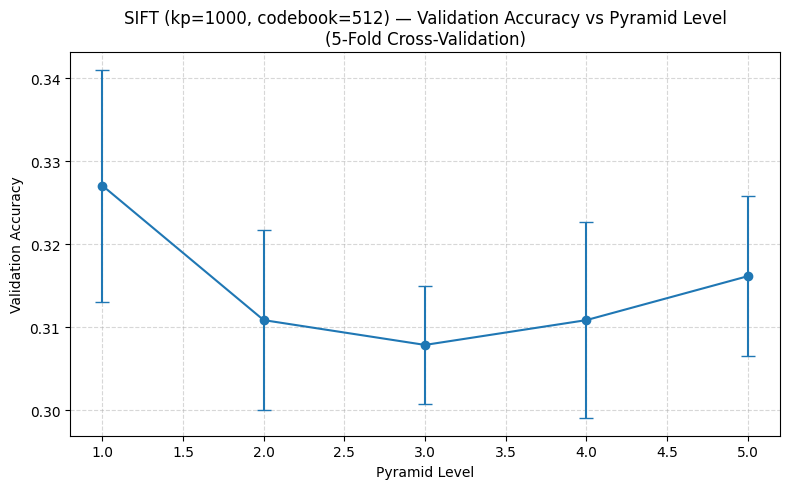

In [9]:
# Plot SIFT (kp=1000, codebook=512) Validation Accuracy vs Pyramid Level (5-Fold CV)

# Since the dataset is reasonably balanced and we use stratified 5-fold cross-validation, 
# accuracy is a reliable metric for evaluating performance in this experiment.

pyramid_levels = list(range(1, 6))

acc_means = [pyramid_results[level].val.accuracy.mean for level in pyramid_levels]
acc_stds  = [pyramid_results[level].val.accuracy.std for level in pyramid_levels]

plot_cv_accuracy(
    x_values=pyramid_levels,
    means=acc_means,
    stds=acc_stds,
    descriptor_name="SIFT (kp=1000, codebook=512)",
    hyperparam_name="Pyramid Level"
)

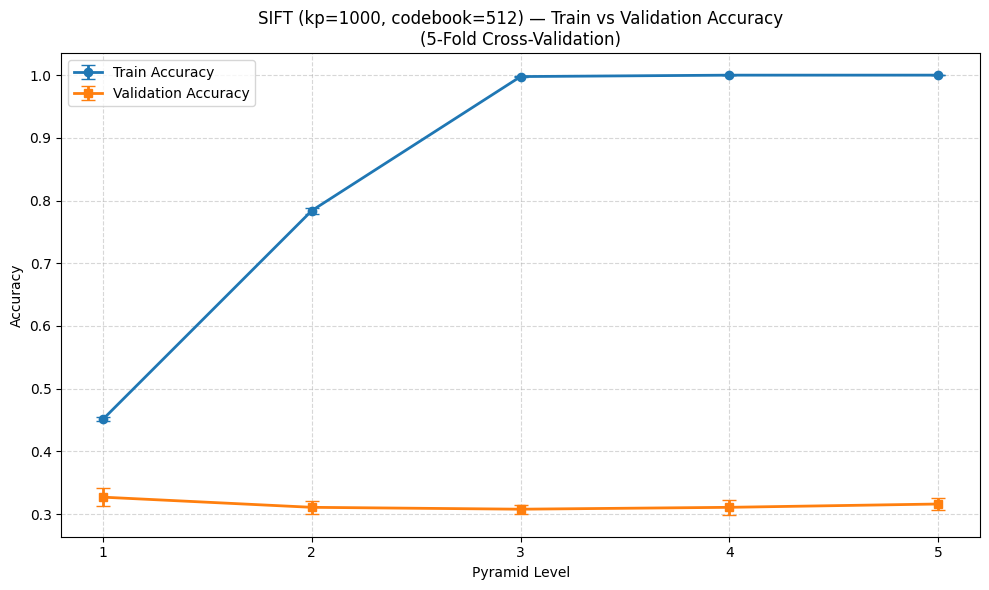

SPATIAL PYRAMIDS: TRAIN vs VALIDATION COMPARISON
--------------------------------------------------------------------------------
Level 1:
  Train Accuracy: 0.4514 ± 0.0035
  Val Accuracy:   0.3271 ± 0.0140
  Gap (Train - Val): 0.1243

Level 2:
  Train Accuracy: 0.7840 ± 0.0049
  Val Accuracy:   0.3109 ± 0.0108
  Gap (Train - Val): 0.4731

Level 3:
  Train Accuracy: 0.9977 ± 0.0008
  Val Accuracy:   0.3079 ± 0.0071
  Gap (Train - Val): 0.6898

Level 4:
  Train Accuracy: 1.0000 ± 0.0001
  Val Accuracy:   0.3109 ± 0.0118
  Gap (Train - Val): 0.6891

Level 5:
  Train Accuracy: 1.0000 ± 0.0000
  Val Accuracy:   0.3162 ± 0.0097
  Gap (Train - Val): 0.6838



In [10]:
# Compare Train vs Validation Metrics across Pyramid Levels

train_means = [pyramid_results[level].train.accuracy.mean for level in pyramid_levels]
train_stds = [pyramid_results[level].train.accuracy.std for level in pyramid_levels]
 
plt.figure(figsize=(10, 6))
plt.errorbar(pyramid_levels, train_means, yerr=train_stds, marker='o', capsize=5, label='Train Accuracy', linewidth=2)
plt.errorbar(pyramid_levels, acc_means, yerr=acc_stds, marker='s', capsize=5, label='Validation Accuracy', linewidth=2)

plt.title("SIFT (kp=1000, codebook=512) — Train vs Validation Accuracy\n(5-Fold Cross-Validation)")
plt.xlabel("Pyramid Level")
plt.ylabel("Accuracy")
plt.xticks(pyramid_levels)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# Print detailed comparison
print("SPATIAL PYRAMIDS: TRAIN vs VALIDATION COMPARISON")
print("-" * 80)
for level in pyramid_levels:
    print(f"Level {level}:")
    print(f"  Train Accuracy: {pyramid_results[level].train.accuracy.mean:.4f} ± {pyramid_results[level].train.accuracy.std:.4f}")
    print(f"  Val Accuracy:   {pyramid_results[level].val.accuracy.mean:.4f} ± {pyramid_results[level].val.accuracy.std:.4f}")
    print(f"  Gap (Train - Val): {pyramid_results[level].train.accuracy.mean - pyramid_results[level].val.accuracy.mean:.4f}")
    print()

In [ ]:
# Tested on the held-out test set using the best pyramid level selected by cross-validation
best_pyramid_level = pyramid_levels[np.argmax(acc_means)]

bovw_params = {
    "detector_type": "SIFT",
    "codebook_size": 512,
    "pyramid_levels": best_pyramid_level,
    "detector_kwargs": {"nfeatures": 1000},
}

classifier_cls = LogisticRegression
classifier_params = {
    "max_iter": 1000,
    "class_weight": "balanced",
}
bovw = BOVW(**bovw_params)
classifier = classifier_cls(**classifier_params)
sift_pyr_bovw, sift_pyr_classifier = train(dataset=data_train, bovw=bovw, classifier=classifier)

sift_pyr_acc, sift_pyr_prec, sift_pyr_rec, sift_pyr_f1, sift_pyr_y_test, sift_pyr_y_pred, sift_pyr_y_score = test(dataset=data_test, bovw=sift_pyr_bovw, classifier=sift_pyr_classifier, return_predictions=True)

Phase [Training]: Extracting the descriptors:  37%|███▋      | 3203/8700 [00:06<00:10, 527.89it/s]

In [ ]:
plot_confusion_matrix(sift_pyr_y_test, sift_pyr_y_pred, title=f"SIFT (kp=1000, codebook=512, pyramid={best_pyramid_level}) Confusion Matrix on Test Set")

In [ ]:
plot_multiclass_roc(sift_pyr_y_score, sift_pyr_y_score, figsize=(6,6))

## E) Classifiers and Normalization

Since the way the data is normalized and preprocessed can depend on the classifier, we're going to try this along the different classifiers and its hyperparameter search for Logistic Regression, SVM, KNN

## F) Dimensionality Reduction

We're going to try PCA, SVD, LDA, t-SNE

## G) Fisher Vectors

Finally, we're going to do a fisher vector approach